# Introduce yourself

## Команда:   Andaaaaananana 

Воронкова Анастасия,

Лейтес Анна,

Перцухов Павел.

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Given information about the post and corresponding item. You have to estimate its probability to be sold in 3 days.

In [0]:
# Добавляем папку на гугл-диске
from google.colab import drive
drive.mount('/content/drive')
path = "./drive/My Drive/kaggle"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


pd.options.mode.chained_assignment = None
%matplotlib inline
random_state = 42

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [0]:
def conf_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=['Predicted neg','Predicted pos'], index = ['True neg','True pos'])


# Data Loading

In [0]:
df = pd.read_csv(f'{path}/train.tsv.gz', sep='\t', index_col=0)
df_test = pd.read_csv(f'{path}/test_nolabel.tsv.gz', sep='\t', index_col=0)

In [0]:
# Set types of columns

def make_ints(df):
    df.delivery_available = df.delivery_available.astype('int')
    df.payment_available = df.payment_available.astype('int')

make_ints(df)

# df.date_created = pd.to_datetime(df.date_created)

def max_text_width(width=50):
    pd.set_option('display.max_colwidth', width)


max_text_width(200)
df.head(10)

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,0,"Продаю стол раскладной, деревянный, советский на века. Состояние осень хорошее. Торг уместен. Самовывоз ФМР",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': 'Тип', 'value': 'Столы', 'value_id': 9490}]",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. Все ранешний фарфор. В другом пакете современные блюдца, чашки и чайник с мишкой Тедди. Ничем практически не пользовались",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_name': 'Тип', 'value': 'Тарелки', 'value_id': 9461}]",Тюменская область,1,405,0
4,9,Омск,2018-07-31,1,"Новый,с этикеткой. Размер L. Не подошёл по размеру,маломерит на размер. Померить можно ул. 25 Линия 74. В любое удобное для вас время.",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,"[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kostyumy_tip', 'slug_name': 'Тип', 'value': 'Костюмы с юбкой', 'value_id': 8362}, {'slug_id': 'zhenskaya_odezhda_razmer', 'slug_name': 'Размер', 'value': '...",Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,0,"Складывается тростью, все колеса вниз. Сплошная ручка, сама стоит в сложенном виде, капюшон закрывает до бампера, передние колеса одинарные, по снегу и каше едут. Это аналог пег перего си, только ...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип', 'value': 'Прогулочная', 'value_id': 8615}, {'slug_id': 'waggon_max_age', 'slug_name': 'Возраст', 'value': 'До 3 лет', 'value_id': 8620}]",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,0,"Неразлучники, птичкам по 1,5 года. Продаю с большой клеткой, кормушками и поилкой",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0
11,11,Гусь-Хрустальный,2018-04-28,0,"Продам детский велосипед,двухколесный,лет для 5-6ти. Маленьких боковых колес нет.",1,55.6063,40.6564,Велосипед детский,9ba6bb7a01bf0e577a36682da64a5dde,1,800.0,c73fd3f12f71c73ad4fa9c1b4b4f3629,1,"[{'slug_id': 'sport_tzvet', 'slug_name': 'Цвет', 'value': 'Зеленый', 'value_id': 10188}, {'slug_id': 'velosipedy_tip', 'slug_name': 'Тип', 'value': 'Городские, дорожные', 'value_id': 10173}]",Владимирская область,1,1107,0
12,5,Якутск,2018-02-08,0,"Отдам кота, 8 месяцев, к горшку приучен.",1,62.0355,129.6755,скоттиш страйт,7e0e13efb64cfbb1daf62a87ed63bf1f,0,1.0,be19161f29cc7e6e1795f756ef9e29e0,1,"[{'slug_id': 'koshki_poroda', 'slug_name': 'Порода', 'value': 'Шотландская', 'value_id': 10437}]",Республика Саха (Якутия),1,503,0
13,13,Краснодар,2018-10-14,0,ТВ в рабочем состоянии,3,45.0618,38.9170,LE32R72B,e8e578f2dd291cc1b2e5944cb869028a,0,6000.0,c76ee67dfc81c0f06a3d908370a2f59e,1,"[{'slug_id': 'televizory_marka', 'slug_name': 'Марка', 'value': 'Samsung', 'value_id': 9612}, {'slug_id': 'televizory_tip', 'slug_name': 'Тип', 'value': 'ЖК, LED', 'value_id': 9588}, {'slug_id': '...",Краснодарский край,1,1302,0
14,25,Орск,2018-06-02,0,1991 г.в.Пробег около 20000 км. Документы есть. Полностью на ходу.,2,51.2585,58.6035,Минск,a992d673ee26064a0e9d157296244739,0,15000.0,c19620c06a40e40445854c4f665416da,1,"[{'slug_id': 'motocikly_skutery_tip', 'slug_name': 'Тип', 'value': 'Дорожные мотоциклы', 'value_id': 11382}]",Оренбургская область,1,2503,0
15,2,Москва,2018-06-20,0,Продаю срочно бу хорошем состоянии два по 1.5 метра витрина и шкаф большой для воды,3,55.8134,37.5958,Холодильники бу,fd9f4d97a20b9d279de9b45ba78d5874,1,12000.0,22670ae3efc3d73a3bec355ce05561ea,1,"[{'slug_id': 'oborudovanie_tip'

In [0]:
len(df),len(df_test)

(351281, 89251)

In [0]:
df.sort_values(by='date_created').head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
221737,12,Архангельск,2018-01-01,1,"iPhone 5 c желтого цвета в отличном состоянии,в подарок силиконовый прозрачный чехол.",2,64.5389,40.5404,iPhone 5 c,0c98f60d0b5e22fac72460479ab2ef51,1,5500.0,60a814a6806be7fb22b89a52f789b91f,1,"[{'slug_id': 'phone_brand', 'slug_name': 'Марка', 'value': 'Apple', 'value_id': 8889}, {'slug_id': 'smartfony_os', 'slug_name': 'Операционная система', 'value': 'iOS', 'value_id': 8930}, {'slug_id...",Архангельская область,1,1202,1
380921,12,Химки,2018-01-01,1,"Процессор: 1300 Мгц (4-ядерный), граф.процессор Память: 4 Гб + 32 Гб, 512 Мб RAM, microSDHC, microSD Платформа: Android 4.2 Аккумулятор: 2000 мА*ч Li-Ion, 13 ч разг.(GSM), 9 ч разг.(WCDMA) Экран: ...",4,55.8786,37.4247,Смартфон Alcatel 7041d,2ac5c9ad2db6f768866617027c1c7872,1,1500.0,2b63b6e7801993186e12c98481bec1fc,1,"[{'slug_id': 'smartfony_slot_dlya_karty_pamyaty', 'slug_name': 'Слот для карты памяти', 'value': 'Есть', 'value_id': 8948}, {'slug_id': 'smartfony_kolichestvo_sim_kart', 'slug_name': 'Количество S...",Московская область,1,1202,1
202514,2,Новокузнецк,2018-01-01,0,"Стиралка и центрифуга ФЕЯ. НА ДАЧУ, ВСЁ В РАБОЧЕМ СОСТОЯНИИ. СТОИТ БЕЗ ДЕЛА.",3,53.8346,87.1962,ФЕЯ - 2,2cf71c0e569fbc2c8e27baf355119980,0,1000.0,f7cba720bb7c713f3356f85410b75ccf,1,[],Кемеровская область,1,208,0
261414,15,Нижний Тагил,2018-01-01,0,Видеокарта на 1 GB В отличном состоянии,1,57.9136,59.9734,Geforce 210 1gb,adf8a79665003f75c58c0d9da120488b,1,1000.0,db0676571b71324354300c26aed4874a,1,"[{'slug_id': 'kompjuteri_komplektuyushchie_ustrojstvo', 'slug_name': 'Устройство', 'value': 'Для компьютеров', 'value_id': 9400}, {'slug_id': 'kompjuteri_komplektuyushchie_tip', 'slug_name': 'Тип'...",Свердловская область,1,1508,1
368416,15,Москва,2018-01-01,0,"Мать: Asus P8H77-M PRO Процессор: Intel Core i7-3770 3,4Ghz Память: Kingston 8Gb DDR3 1333Mhz Видео: Asus GeForce GT240 Корпус Asus midi tower 450 ватт SSD 120Gb + HDD 500Gb",1,55.8584,37.5033,Системный блок,39d6d4a848aca2408c364336d2cf22e7,1,20000.0,0f5ed5c414e39cf99ea276d4d0289ecb,1,"[{'slug_id': 'kompyutery_tip', 'slug_name': 'Тип', 'value': 'Настольные, системные блоки', 'value_id': 9262}]",Московская область,1,1502,0


# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

In [0]:
# Соотношение числа представителей классов

print('positive:', sum(df.sold_fast == 1))
print('negative:', sum(df.sold_fast == 0))
print('ratio:', np.mean(df.sold_fast))

positive: 81080
negative: 270201
ratio: 0.23081236958446372


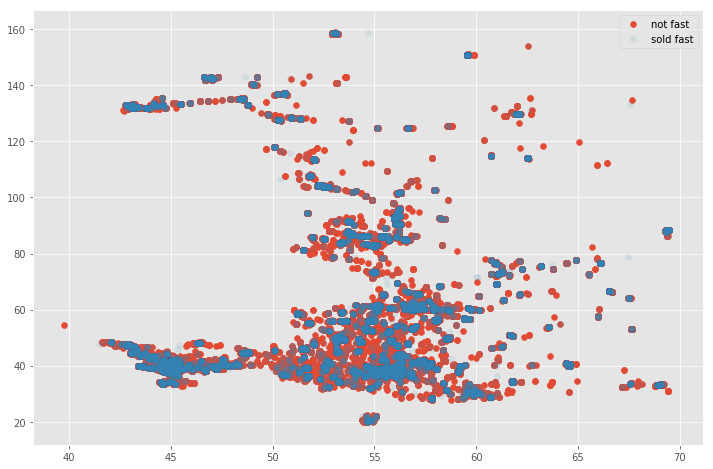

In [0]:
# Геопозиция и скорость продаж - не похоже что сильно связаны
df0 = df[df.sold_fast == 0]
df1 = df[df.sold_fast == 1]
plt.scatter(x='lat', y='long', data=df0,alpha=1,label='not fast') 
plt.scatter(x='lat', y='long', data=df1,alpha=0.1,label='sold fast') 
plt.legend();

Посмотрим на все числовые фичи - хорошо коррелируют payment_available, delivery_available и product_type c img_num, цена с product_type, img_num, payment_available

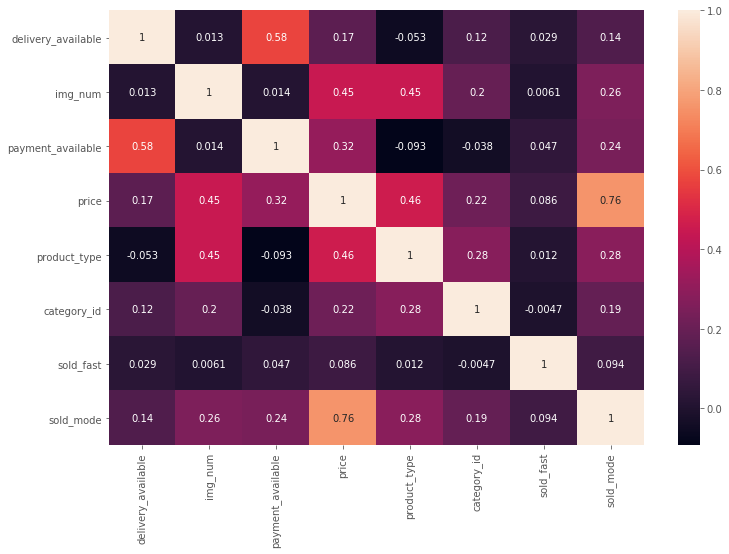

In [0]:
df2 = df[['delivery_available','img_num','payment_available','price','product_type','category_id','sold_fast','sold_mode']]
df2.loc[df2.price== 0,:] = 0.0001
df2.loc[:,'price'] = np.log10(df2.loc[:,'price'])
sns.heatmap(df2.corr(),annot=True)

Цена и скорость продажи - при высокой цене продукты не очень быстро продаются, но в среднем не очень связаны

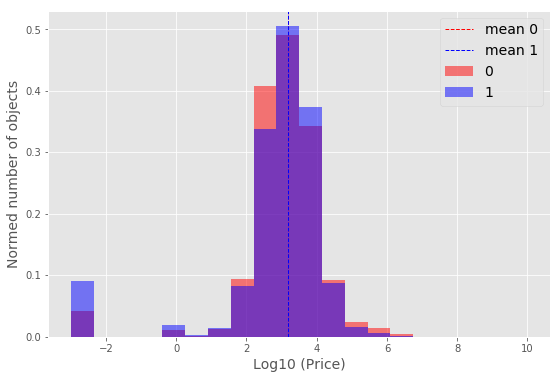

In [0]:
df.loc[df.price== 0,'price'] = 0.001
feature_values = np.log10(df.price.values)
labels = df.sold_fast.values
feature_values_notnull = feature_values[feature_values!=-3]
labels_notnull = labels[feature_values!=-3]

plt.figure(figsize=(9, 6))
bins = np.linspace(-3, 10, 21)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values_notnull[labels_notnull == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values_notnull[labels_notnull == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Log10 (Price)', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

## Work with cities

In [0]:
pd.DataFrame(df.groupby('region').sold_fast.mean().sort_values(ascending=False)).head()#.where(lambda x : (x<1) & (x>0)).dropna()

,sold_fast
region,
Абинск,1.0
Электросталь,1.0
Бор,1.0
Череповец,1.0
Челябинск,1.0


In [0]:
pd.DataFrame(df.groupby('category_id').sold_fast.mean().sort_values(ascending=False)).head()#.where(lambda x : (x<1) & (x>0)).dropna()

,sold_fast
category_id,
2,0.328338
12,0.293339
13,0.275721
15,0.263248
10,0.260657


Добавляем перевод названий городов на английский (Yandex-transtate)



In [0]:
# save cities
cities = df.city.unique()
#np.savetxt('cities.txt', cities,'%s') 

# load translated city names(by Yandex-translate:)
translated = pd.read_table(f'{path}/translated_cities.txt',header=None)
translated.columns = ['city_en']
city = pd.concat([translated, pd.Series(cities,name='city')],axis=1)
city.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


,city_en,city
0,Krasnodar,Краснодар
1,Tyumen,Тюмень
2,Omsk,Омск
3,Saint-Petersburg,Санкт-Петербург
4,Moscow,Москва


Была идея вычислять расстояние до центра города и nominatim как раз умеет возвращать координаты по названию города, а geopy - считать расстояние в километрах, но он не дает это делать, т.к. число городов у нас больше установленного максимального числа запросов

In [0]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# получаем координаты
#geolocator = Nominatim()
#locatio n = geolocator.geocode("Omsk")
#pos = (location.latitude, location.longitude)
#print(location, pos)

# cчитаем расстояние
#place = df[df.city == 'Омск'].iloc[121]
#distance = geodesic(pos,(place.lat, place.long))
#print(distance.km)

def get_location(name):
    geolocator = Nominatim()
    location = geolocator.geocode(name)
    if location is None:
        return 0
    else:
        return (location.latitude, location.longitude)
#locations = list(map(get_location,city.city_en.values))
#city.location = locations

###Adding city population

Добавляем данные о населении городов и регионов из нескольких источников, т.к. все данные не очень полные

Добавляем данные с википедии https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Russia_by_population

In [0]:
city_population = pd.read_excel(f'{path}/city_population_2010_plus_crimea.xlsx')
city_population = city_population[['Город', 'Население']].dropna()
city_population.columns = ['city', 'population']
city_population = {row.city:row.population for _, row in city_population.iterrows()}

In [0]:
# city_population.sort_values('population', ascending=False).head()
sorted(city_population.items(), key=lambda kv: -kv[1])[:10]

[('Москва', 11514330),
 ('Санкт-Петербург', 4848742),
 ('Новосибирск', 1498921),
 ('Екатеринбург', 1377738),
 ('Нижний Новгород', 1250615),
 ('Казань', 1216965),
 ('Самара', 1164900),
 ('Омск', 1154000),
 ('Челябинск', 1130273),
 ('Ростов-на-Дону', 1091544)]

Добавляем данные из датасета на kaggle "Russian city population" https://www.kaggle.com/stecasasso/russian-city-population

In [0]:
city_population_another = pd.read_csv(f'{path}/city_population.csv')
city_population_another.population = city_population_another.population.astype(int)
city_population_another = {row.city:row.population for _, row in city_population_another.iterrows()}

city_population_another['Большая Орловка'] = 4063
city_population_another['Орловка'] = 847
city_population_another['Александрия'] = 82410

In [0]:
sorted(city_population_another.items(), key=lambda kv: -kv[1])[:10]

[('Центральный', 39311413),
 ('Керчевский', 25003000),
 ('Тимирязевский', 12506468),
 ('Новосибирск', 1602915),
 ('Сибирский', 1602915),
 ('Николаевская', 1602915),
 ('Екатеринбург', 1455904),
 ('Артышта', 1312614),
 ('Нижний Новгород', 1264075),
 ('Советск', 1264075)]

In [0]:
# merging
city_population_merged = city_population_another.copy()
city_population_merged.update(city_population)

In [0]:
# функции для подсчета найденных и ненайденных данных о городах и регионах
def how_much_found(population):
    cities = df.city.unique()

    found = [city for city in cities if city in population]
    not_found = [city for city in cities if city not in population]

    print('found:', len(found))
    print('not found:', len(not_found))
    return not_found

def how_much_found_region(population):
    cities = df.region.unique()

    found = [city for city in cities if city in population]
    not_found = [city for city in cities if city not in population]

    print('found:', len(found))
    print('not found:', len(not_found))
    return not_found

how_much_found(city_population_merged);
how_much_found_region(city_population_merged);

found: 1894
not found: 405
found: 91
not found: 18


Добавляем данные Росстата www.gks.ru/free_doc/new_site/population/demo/perepis2010/svod.xls

In [0]:
svod_population = pd.read_excel(f'{path}/svod_population.xls', skiprows=4, names=['city', 'population']).dropna()
svod_population.city = svod_population.city.apply(lambda x: x.replace('г.', '')
                                                  .replace('пгт ', '')
                                                  .replace('рп ', '')
                                                  .replace('(рц)','')
                                                  .replace('с подчинеными его администрации населенными пунктами','')
                                                  .replace('с подчиненными его администрации населенными пунктами','')
                                                  .replace('Городское население -','')
                                                  .replace('включая Ненецкий автономный округ','')
#                                                   .replace('Республика ','')
                                                  .replace('C', 'С') # !!!!!!!!!!!!!!
                                                  .replace('—','-')
                                                  .strip())
svod_population = svod_population[svod_population.population != '-']
svod_population.population = svod_population.population.astype(int)

svod_population = svod_population[svod_population.city != 'Городское население']
svod_population = svod_population[svod_population.city != 'Сельское население']
svod_population = {row.city:row.population for _, row in svod_population.iterrows()}
# svod_population.pop('Городское население')
# svod_population.pop('Сельское население')
len(svod_population)

4443

In [0]:
sorted(svod_population.items(), key=lambda kv: kv[0])[:10]

[('Абаза', 17111),
 ('Абазинский район', 17189),
 ('Абакан', 165183),
 ('Абанский район', 22580),
 ('Абатский район', 19838),
 ('Абдулино', 20183),
 ('Абдулинский район', 10373),
 ('Абзелиловский район', 45545),
 ('Абинск', 34926),
 ('Абинский район', 91905)]

In [0]:
city_population_merged.update(svod_population)

In [0]:
how_much_found(city_population_merged);

found: 1894
not found: 405


In [0]:
how_much_found_region(city_population_merged)

found: 91
not found: 18


['Тюменская область',
 'Адыгея',
 'Башкортостан',
 'Удмуртия',
 'Дагестан',
 'Республика Крым',
 'Татарстан',
 'Кабардино-Балкария',
 'Чувашия',
 'Мордовия',
 'Северная Осетия',
 'Марий Эл',
 'Карачаево-Черкесия',
 'Чечня',
 'Калмыкия',
 'Россия',
 'Ингушетия',
 'Биокомбината']

Добавляем новые фичи в датасет - city_population и region_population

In [0]:
mean_city = int(np.median(list(city_population_merged.values())))


def get_population(cities, mean_city):
    return [city_population_merged[city] if city in city_population_merged else mean_city for city in cities]


def add_city_region_population(df):
    population_col = get_population(df.city, mean_city)
    population_col_region = get_population(df.region, 1_900_000) # crimea population as default
    df['city_population'] = population_col
    df['region_population'] = population_col_region
    
add_city_region_population(df)

In [0]:
max_text_width(20)
df.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,city_population,region_population
1,4,Краснодар,2018-10-08,0,Продаю стол раск...,3,45.0686,38.9518,Стол,4ce583fe8231a0cc...,1,500.0,8cb80c05c65c2102...,1,[{'slug_id': 'st...,Краснодарский край,1,410,1,744933,5225826
2,4,Тюмень,2018-06-18,0,Тарелки глубокие...,2,57.1840,65.5674,Посуда,e58be2c8f143c172...,0,300.0,3b7a9f8b27a53b63...,1,[{'slug_id': 'do...,Тюменская область,1,405,0,581758,1900000
4,9,Омск,2018-07-31,1,"Новый,с этикетко...",1,54.9889,73.4312,Костюм,51b4087960272142...,1,1100.0,c97dd9c5a3e938c5...,1,[{'slug_id': 'zh...,Омская область,1,908,0,1153971,1977450
6,3,Санкт-Петербург,2018-04-17,0,Складывается тро...,4,59.9590,30.4877,Коляска,6544b83acbbf0443...,1,5000.0,3e5d0286b25fd7f6...,1,[{'slug_id': 'wa...,Ленинградская об...,1,312,0,4848742,1712690
10,5,Москва,2018-02-09,0,"Неразлучники, пт...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47b...,1,2000.0,57b4a8679d0d3eb1...,1,[],Московская область,1,504,0,11514330,7092941


##Plots

связано ли кол-во выставляемых товаров продавцами со скоростью продаж

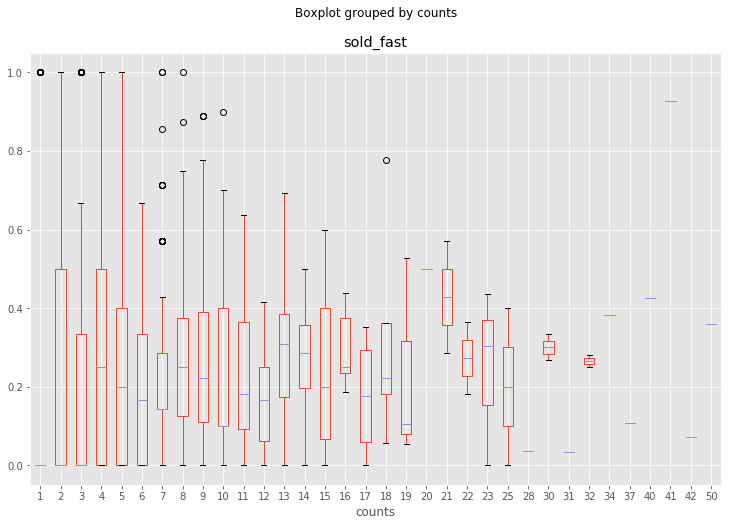

In [0]:
owners = df.groupby(by='owner_id').sold_fast.mean()
counts = df.owner_id.value_counts()
owners_counts = pd.DataFrame({'sold_fast':owners,'counts':counts}).sort_values('counts',ascending =  False)
owners_counts.boxplot('sold_fast','counts')
#owners_counts

Получим категории и субкатегории, которые быстрее всего раскупаются

Text(0.5, 1.0, 'Most popular categories')

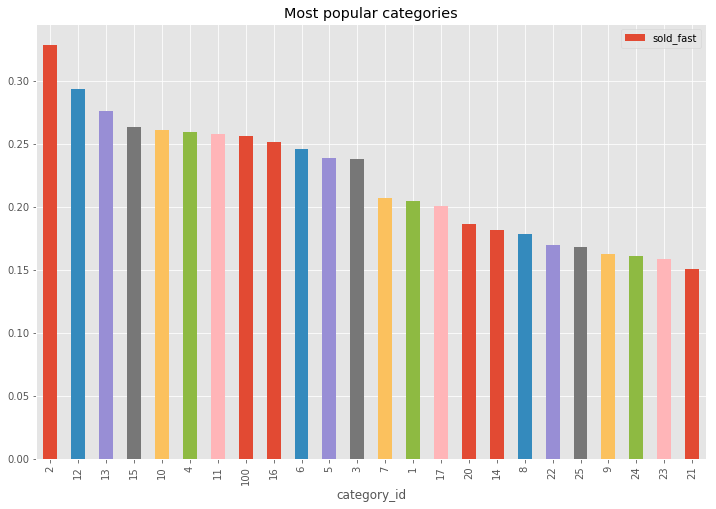

In [0]:
cat = df.groupby(by='category_id').sold_fast.mean()
cat = pd.DataFrame(cat).sort_values(by='sold_fast',ascending=False)
cat.plot.bar(y='sold_fast')
plt.title('Most popular categories')

Text(0.5, 1.0, 'Top subcategories')

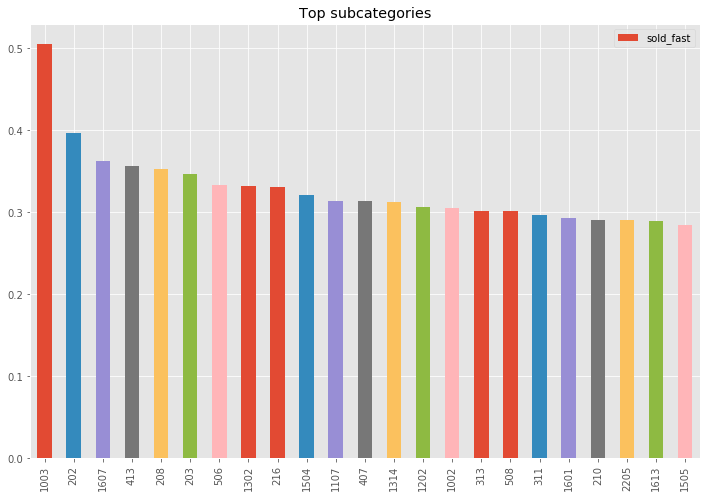

In [0]:
subcat = df.groupby(by='subcategory_id').sold_fast.mean()
counts = df.subcategory_id.value_counts()
subcat = pd.DataFrame({'sold_fast':subcat,'counts':counts})
subcat = subcat.sort_values(by=['sold_fast'],ascending=False).head(30)
subcat = subcat[subcat.counts >= 50]
subcat.plot.bar(y='sold_fast')
plt.title('Top subcategories')


Посмотрим на быстро раскупаемые товары и в каких регионах и городах они чаще

In [0]:
def get_sold_fast(feature, top = 25, min_ratio = None, dataframe = False):
    fig,ax = plt.subplots()
    
    feat = df.groupby(by=['sold_fast',feature])[feature].count()
    feat_sold_fast = feat[1]
    feat_sold_fast = pd.DataFrame({'count_sold_fast':feat_sold_fast})
    feat_sold_fast = feat_sold_fast.sort_values(by='count_sold_fast',ascending=False)
    
    
    count = df[feature].value_counts()
    count.name = 'count_all'
    feat_sold_fast = feat_sold_fast.join(count)
    feat_sold_fast.head(top).plot.bar(y='count_all',ax=ax,color='black',alpha=0.2)
    feat_sold_fast.head(top).plot.bar(y='count_sold_fast',ax=ax)
    plt.title(f'Top {feature} by number of sold_fast')
    
    #feat_sold_fast = feat_sold_fast[feat_sold_fast.count_all > 50]
    feat_sold_fast.loc[:,'ratio'] = feat_sold_fast.count_sold_fast / feat_sold_fast.count_all
    feat_sold_fast = feat_sold_fast.sort_values(by='ratio',ascending=False)
    
    if dataframe: 
        return feat_sold_fast.head(top)
    elif min_ratio is not None:
        feat_sold_fast = feat_sold_fast[feat_sold_fast.ratio>min_ratio]
        return feat_sold_fast
    else:
        feat_sold_fast = feat_sold_fast.head(top)
        feat_sold_fast.plot.bar(y='ratio')
        plt.title(f'Top {feature} by ratio sold_fast/all')
        #feat_sold_fast = feat_sold_fast.sort_values(by='counts_all',ascending=False)
        #feat_sold_fast_top_ratio.plot.bar(y='count_all')
        #plt.title(f'Top {feature} by ratio sold_fast/all - number')
        
        

In [0]:
def get_heatmap(feature):
    feat = df.groupby(by=['sold_fast',feature])[feature].count()
    sns.heatmap(feat.unstack(),annot=True,fmt='.2f',cmap='rocket_r')

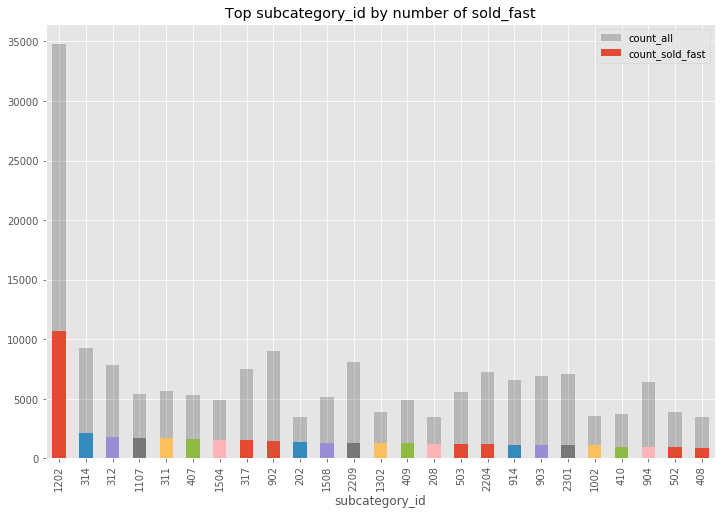

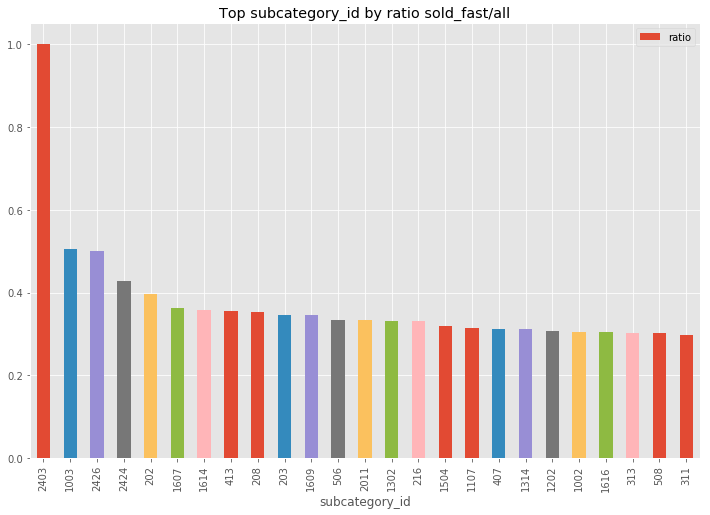

In [0]:
get_sold_fast('subcategory_id')

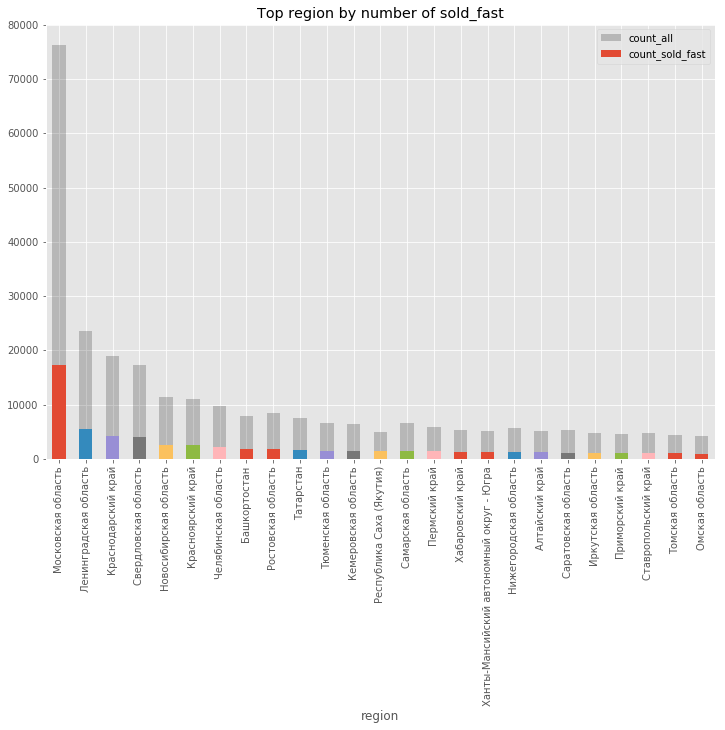

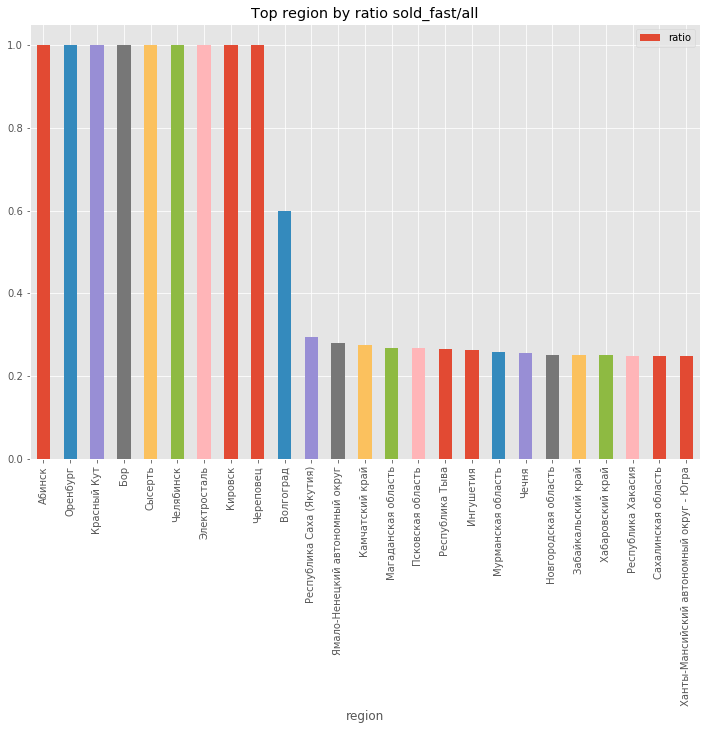

In [0]:
get_sold_fast('region')

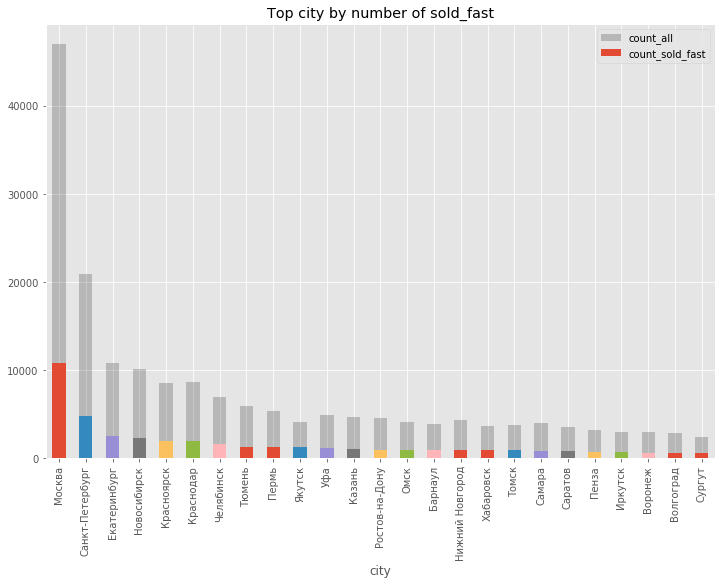

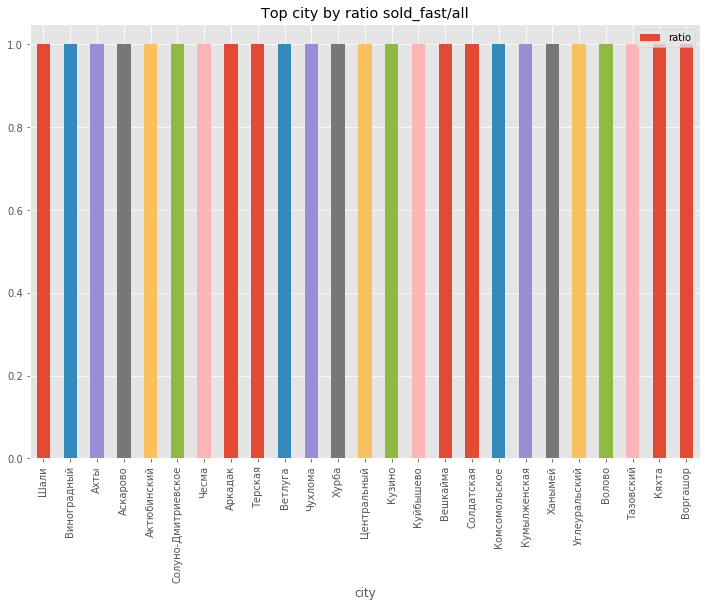

In [0]:
get_sold_fast('city')

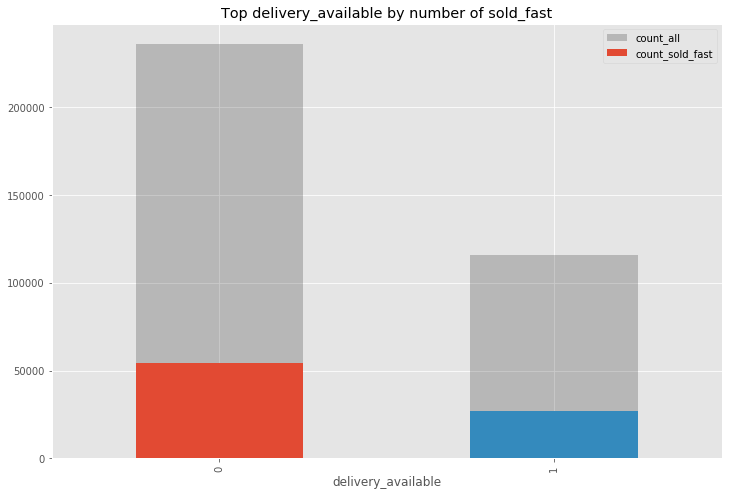

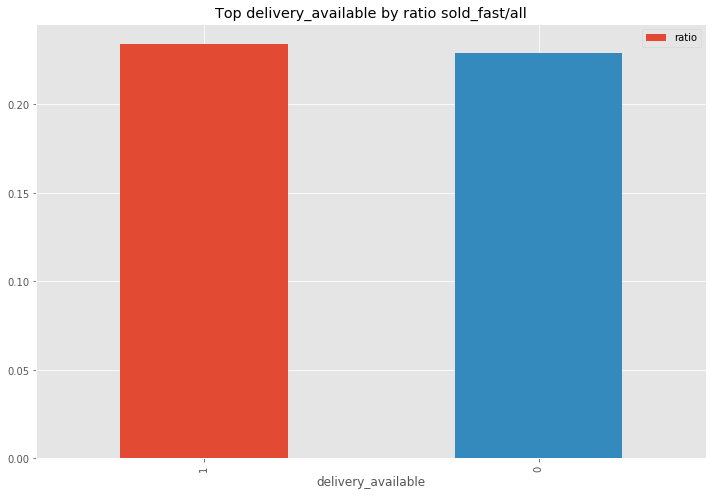

In [0]:
get_sold_fast('delivery_available')

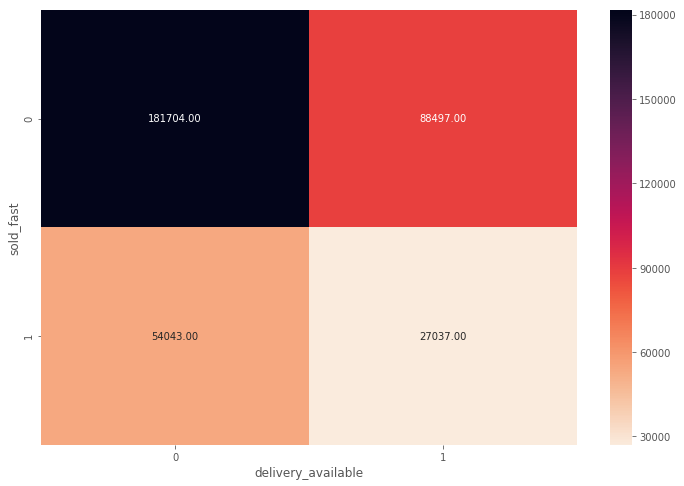

In [0]:
get_heatmap('delivery_available')

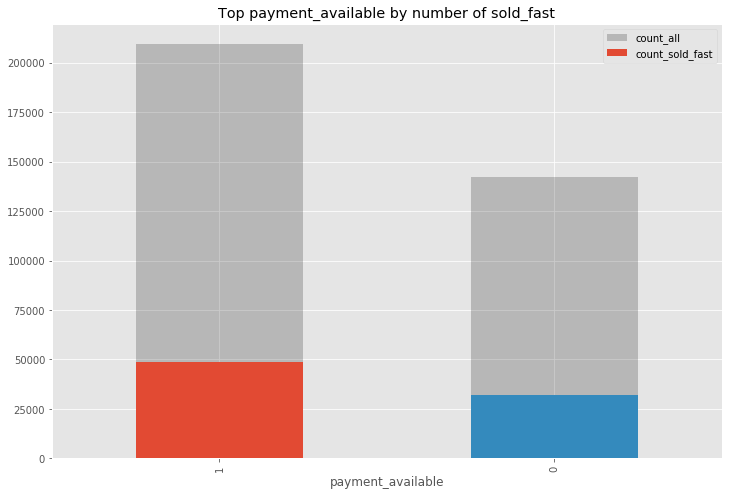

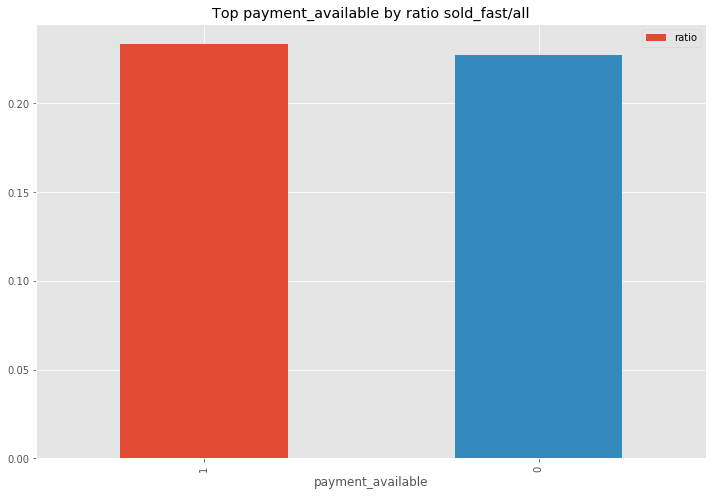

In [0]:
get_sold_fast('payment_available')

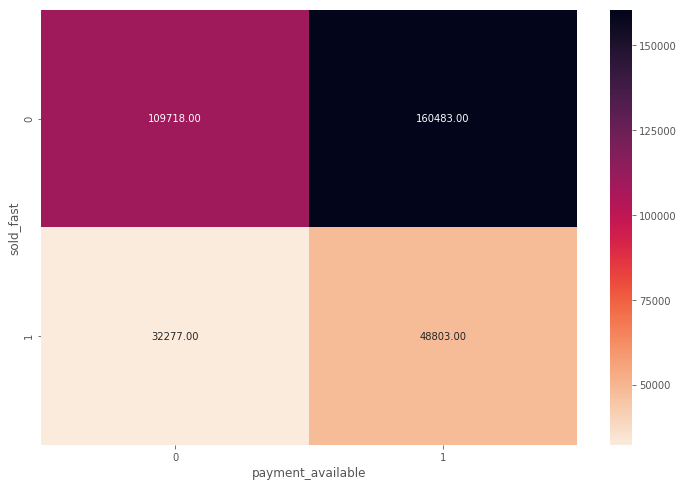

In [0]:
get_heatmap('payment_available')

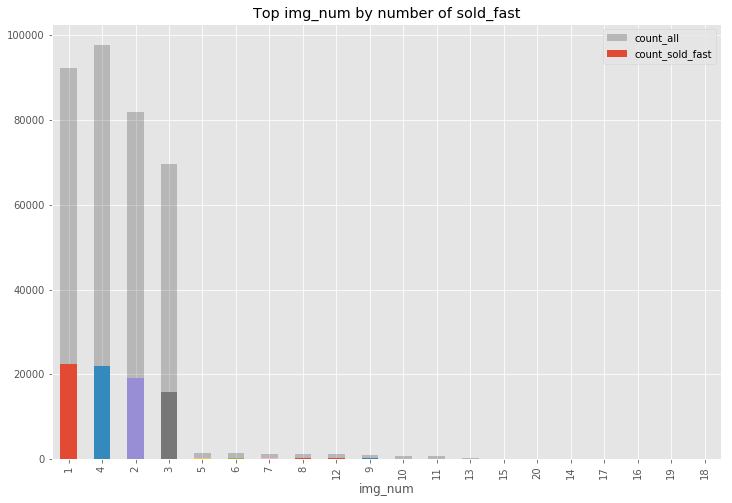

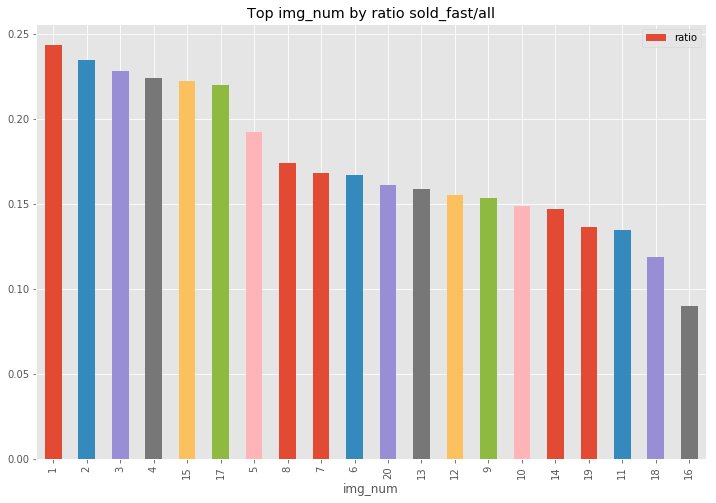

In [0]:
get_sold_fast('img_num')

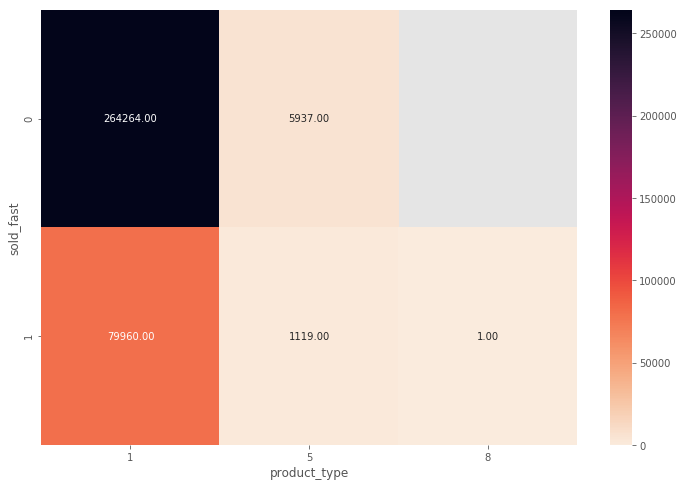

In [0]:
get_heatmap('product_type')

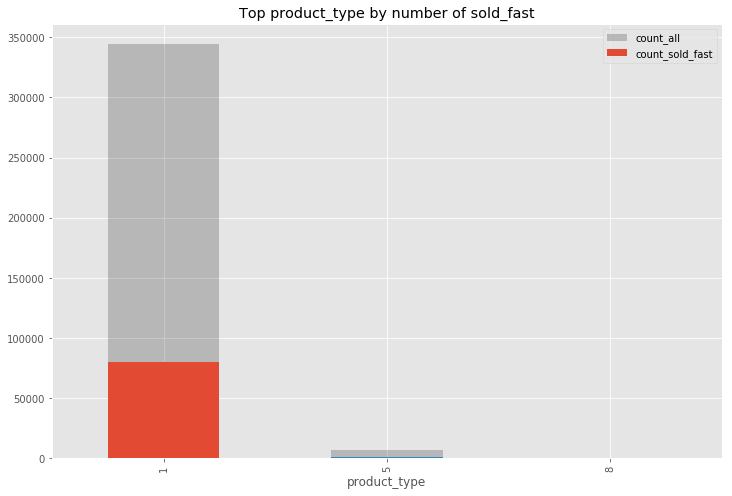

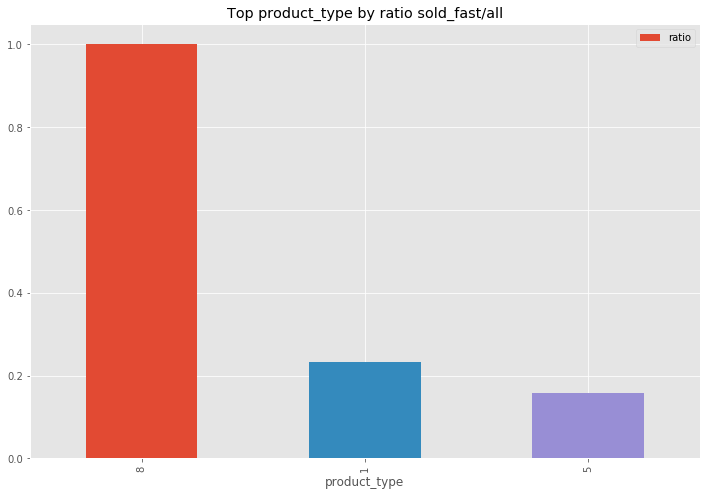

In [0]:
get_sold_fast('product_type')

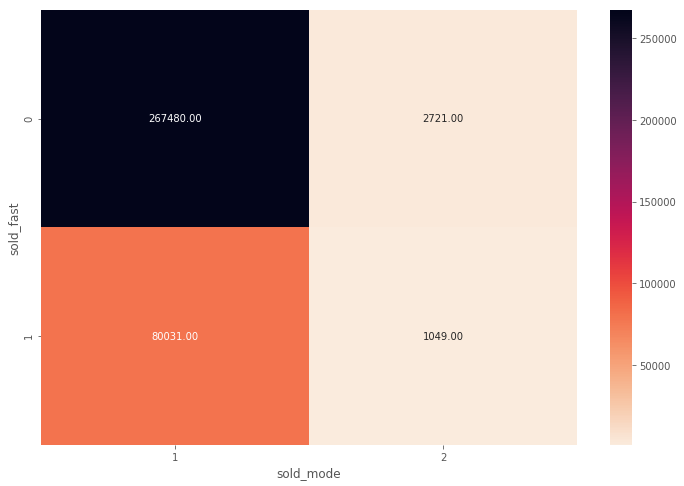

In [0]:
get_heatmap('sold_mode')

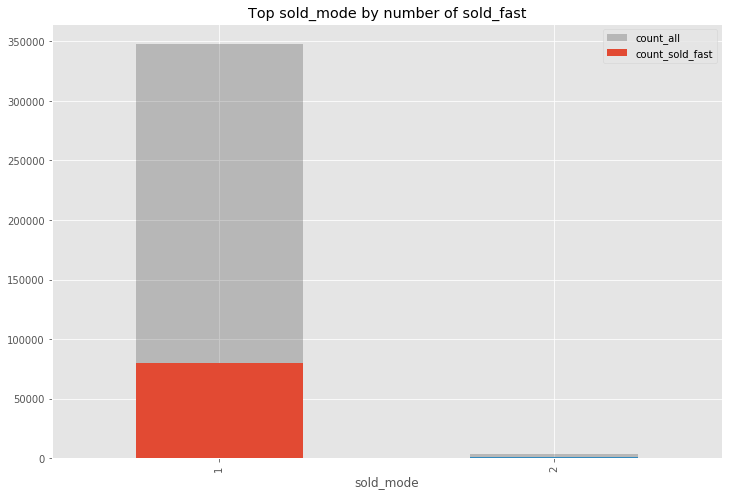

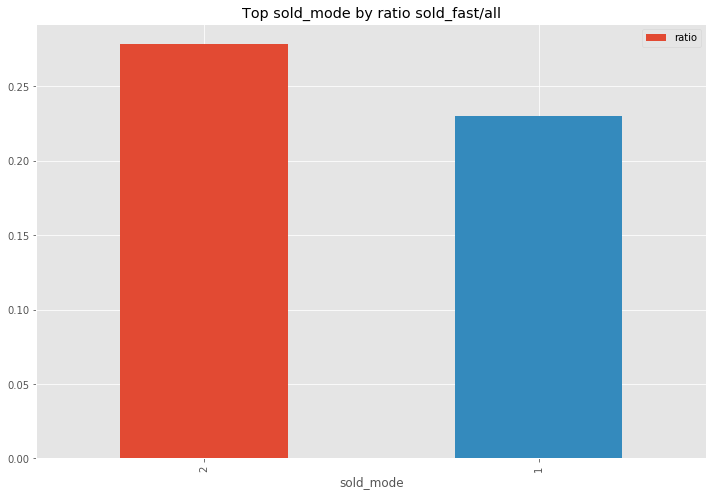

In [0]:
get_sold_fast('sold_mode')

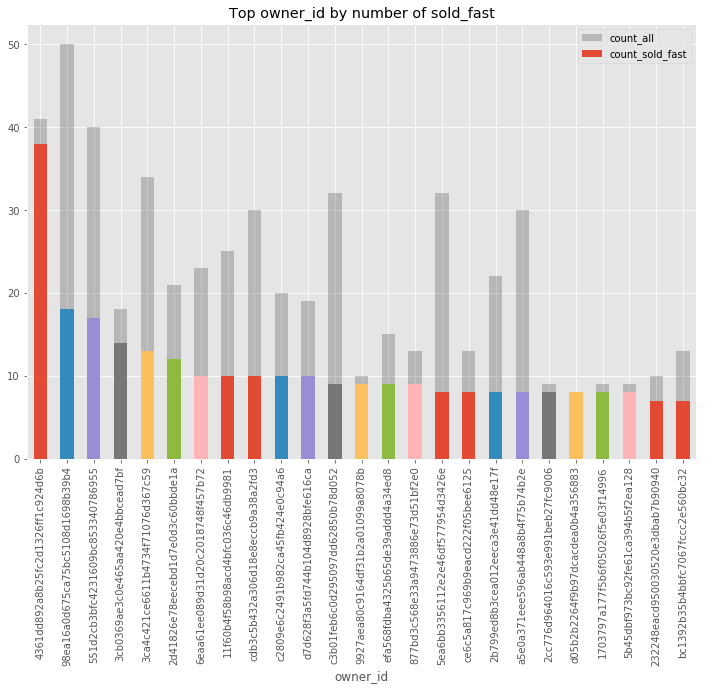

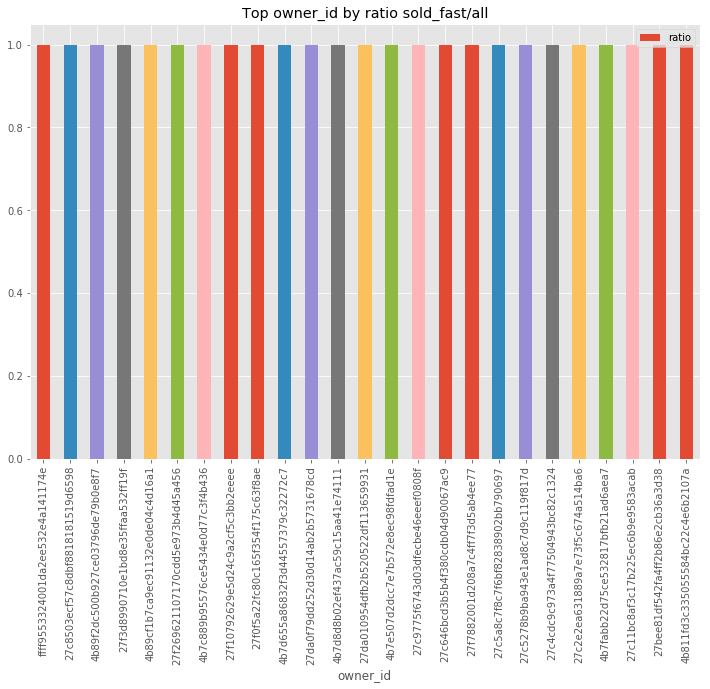

In [0]:
get_sold_fast('owner_id')

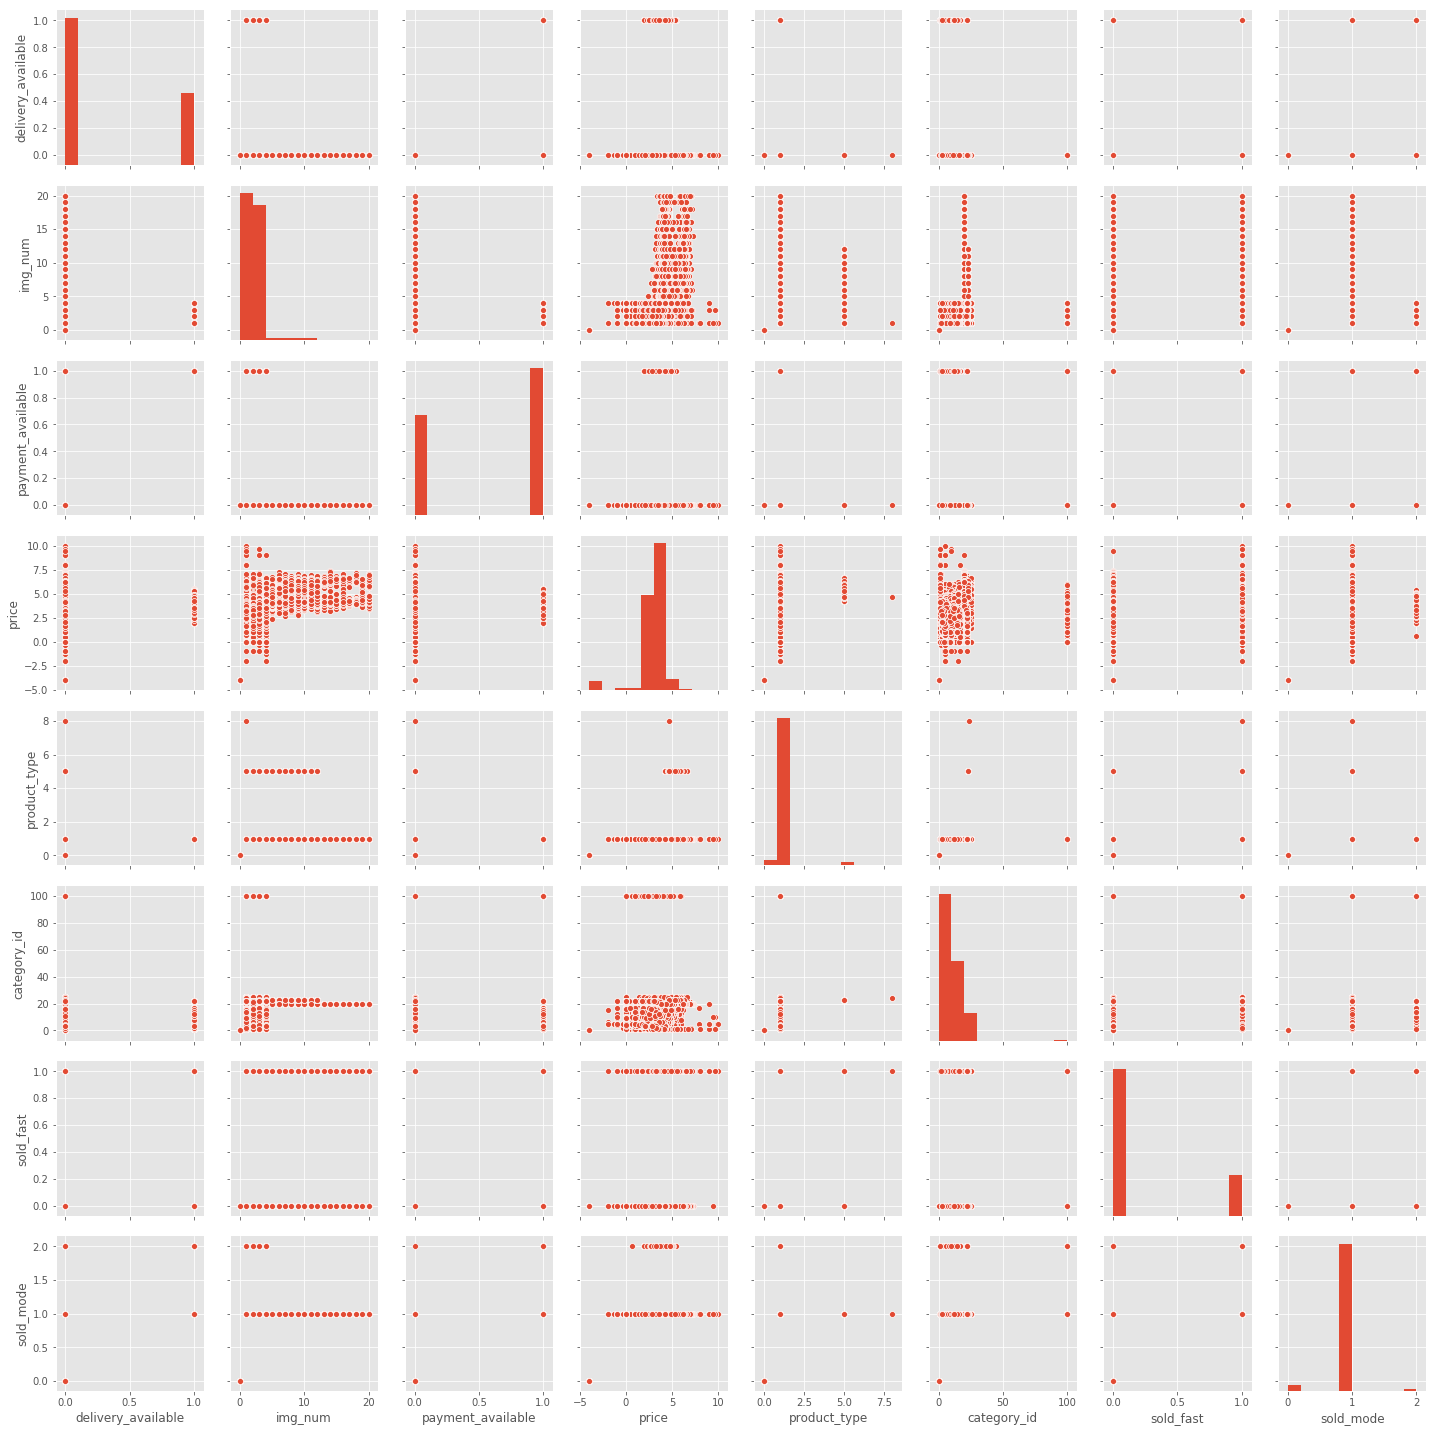

In [0]:
# много графиков
sns.pairplot(df2)

## Working with dates

In [0]:
def add_dates(df):
    df.date_created = pd.to_datetime(df.date_created)
    # Add date info
    df['day'] = df.date_created.apply(lambda x: x.day)
    df['month'] = df.date_created.apply(lambda x: x.month)
    df['weekday'] = df.date_created.apply(lambda x: x.isoweekday())
add_dates(df)

In [0]:
max_text_width(20)
df.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,city_population,region_population,day,month,weekday
1,4,Краснодар,2018-10-08,0,Продаю стол раск...,3,45.0686,38.9518,Стол,4ce583fe8231a0cc...,1,500.0,8cb80c05c65c2102...,1,[{'slug_id': 'st...,Краснодарский край,1,410,1,744933,5225826,8,10,1
2,4,Тюмень,2018-06-18,0,Тарелки глубокие...,2,57.1840,65.5674,Посуда,e58be2c8f143c172...,0,300.0,3b7a9f8b27a53b63...,1,[{'slug_id': 'do...,Тюменская область,1,405,0,581758,1900000,18,6,1
4,9,Омск,2018-07-31,1,"Новый,с этикетко...",1,54.9889,73.4312,Костюм,51b4087960272142...,1,1100.0,c97dd9c5a3e938c5...,1,[{'slug_id': 'zh...,Омская область,1,908,0,1153971,1977450,31,7,2
6,3,Санкт-Петербург,2018-04-17,0,Складывается тро...,4,59.9590,30.4877,Коляска,6544b83acbbf0443...,1,5000.0,3e5d0286b25fd7f6...,1,[{'slug_id': 'wa...,Ленинградская об...,1,312,0,4848742,1712690,17,4,2
10,5,Москва,2018-02-09,0,"Неразлучники, пт...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47b...,1,2000.0,57b4a8679d0d3eb1...,1,[],Московская область,1,504,0,11514330,7092941,9,2,5


Видим что продажи по дням недели не сильно отличаются, но  товары выставленные по субботам скорее продаются, чем нет, а по воскресеньям - наоборот, по пятницам все сидят в барах, а не занимаются продажами, быстрее продаются товары выставленные во вторник

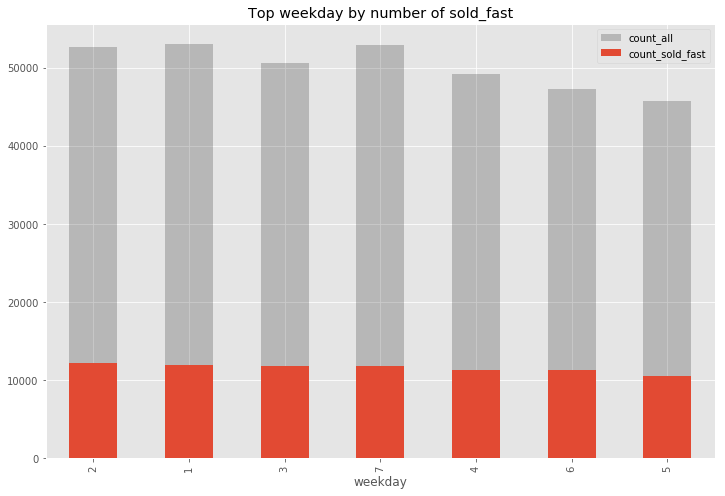

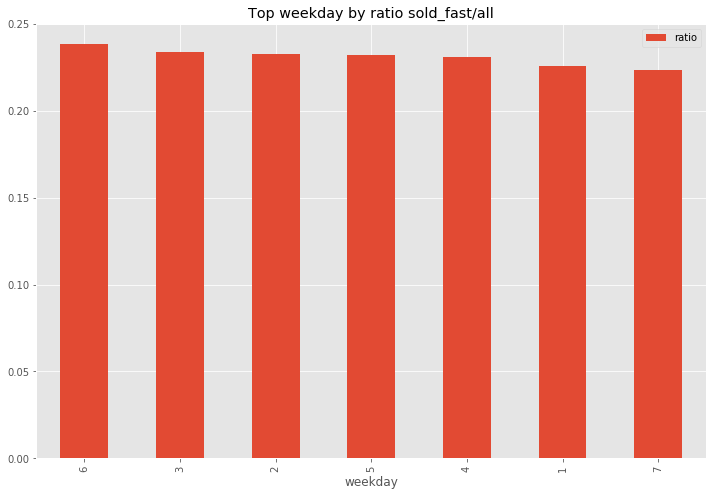

In [0]:
get_sold_fast('weekday')

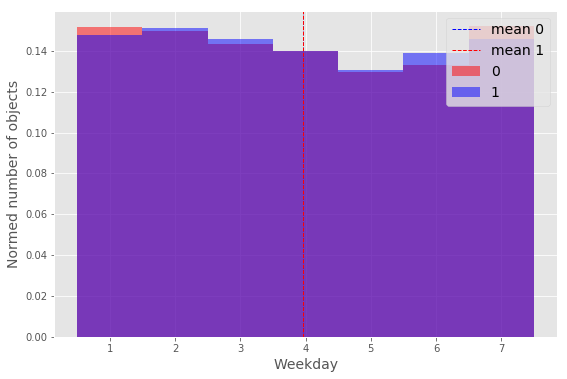

In [0]:
feature_values = df.weekday
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 7.5, 8)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values[labels == 1].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values[labels == 0].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Weekday', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Месяц - важная фича, так в весенне-летний период продукты скупаются быстрее, но больше товаров выставляется в 1 квартале года

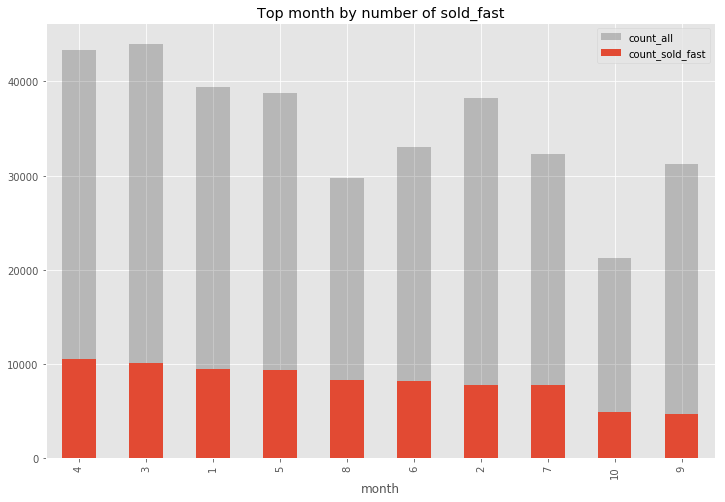

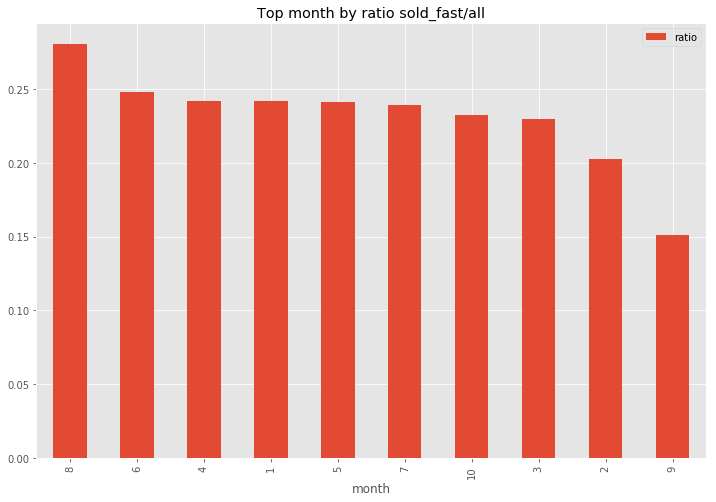

In [0]:
get_sold_fast('month')

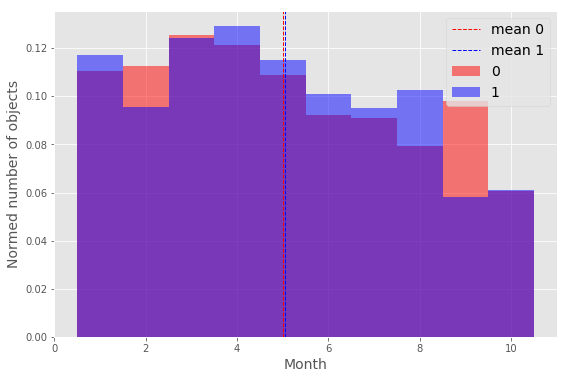

In [0]:
feature_values = df.month
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 10.5, 11)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values[labels == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values[labels == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Month', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

Видим, что в среднем к концу месяца покупают товары быстрее, чем в начале месяца

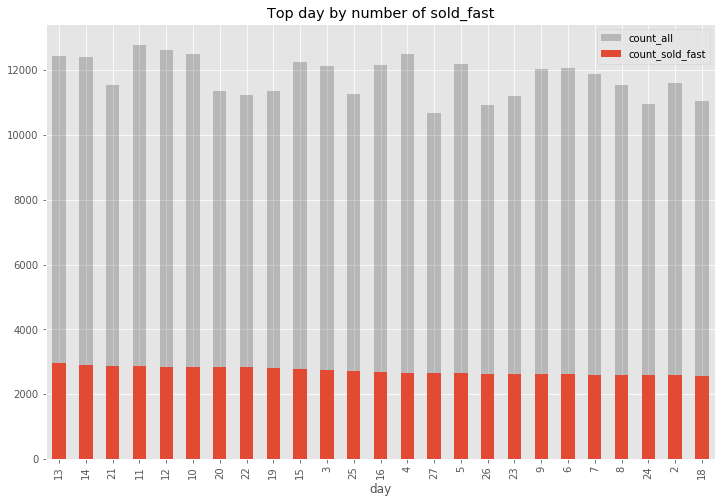

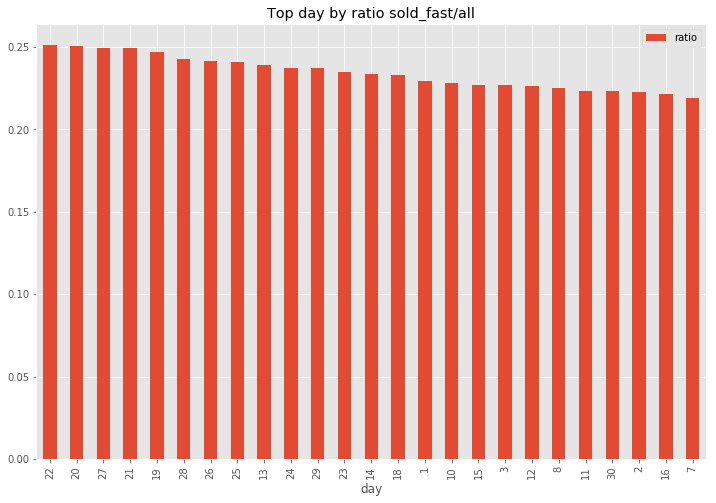

In [0]:
get_sold_fast('day')

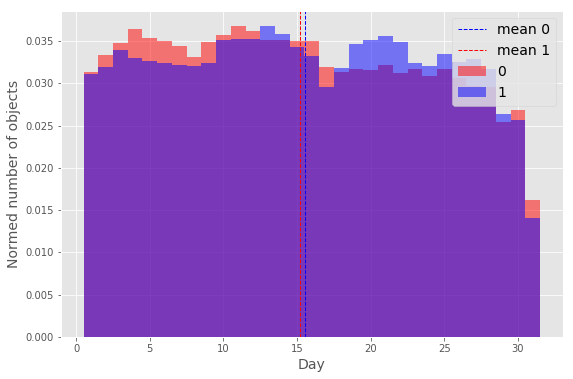

In [0]:
feature_values = df.day
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 31.5, 32)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values[labels == 1].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values[labels == 0].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Day', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

## Working with text

In [0]:
!pip install pymorphy2[fast]
import pymorphy2

!pip install nltk
!pip install fasttext

import nltk
nltk.download("stopwords")

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 7.1MB 12.6MB/s 
     |████████████████████████████████| 256kB 50.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/d4/88/d0/4e4abc83eb8f59a71e8dbd8ba99fd5615a3af1fac1ef7f8825
Successfully built DAWG
     |████████████████████████████████| 81kB 5.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/73/8e/5d/ecb50b90adaab5868ae1d8df180f31e55e85c2f055aaf2fb35
Successfully built fasttext
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#russian lemmatizer
from tqdm import tqdm, tqdm_notebook
from nltk.corpus import stopwords
from string import punctuation
import re

#only russian words
def russian_tokenizer(text):
    return re.findall('\\b[а-яА-ЯёЁ\-/]+\\b', text) # '/' for word б/у

def another_tokenizer(text):
    return re.findall('\\b[а-яА-ЯёЁ\-\\w\\d/]+\\b', text) # '/' for word б/у

word_punct_tokenizer = nltk.WordPunctTokenizer().tokenize

def add_lemmatized_descr(df):
#     texts = np.array(df.desc_text)
    lemmatized_texts = []


    morph = pymorphy2.MorphAnalyzer()
    russian_stopwords = stopwords.words("russian")

    for desc, name in tqdm_notebook(list(zip(df.desc_text, df.name_text))):
        # combine name and description
        text = name + '. ' + desc
        lemmatized_words = []

#         splitted = another_tokenizer(text)
        splitted = word_punct_tokenizer(text)
    
        for word in splitted:

            parsed_word = morph.parse(word)[0]
            normed_word = parsed_word.normal_form

            if normed_word not in russian_stopwords:
                lemmatized_words.append(normed_word)

        lemmatized_text = ' '.join(lemmatized_words)
        lemmatized_texts.append(lemmatized_text)
    
    df['lemmatized_descr'] = lemmatized_texts
    return lemmatized_texts


def save_lemmatized_descr(texts, save_file):
    print('saving')
    
    with open(f'{path}/{save_file}', 'w') as f:
        f.write('\n'.join(texts))
    print('saved')

def restore_lemmatized_descr(df, load_file):
    with open(f'{path}/{load_file}', 'r') as f:
        lemmatized_descr = f.read().split('\n')
        df['lemmatized_descr'] = lemmatized_descr
        
        return lemmatized_descr

In [0]:
%%time
texts = np.array(df.desc_text)

# lemmatized_texts = add_lemmatized_descr(df)
# save_lemmatized_descr(lemmatized_texts, 'df_lemmatized_descr.txt')
lemmatized_texts = restore_lemmatized_descr(df, 'df_lemmatized_descr.txt')

CPU times: user 727 ms, sys: 546 ms, total: 1.27 s
Wall time: 2.52 s


In [0]:
max_text_width(500)
pd.DataFrame(list(zip(lemmatized_texts[:10], texts[:10])), columns=['normed', 'text'])

,normed,text
0,"стол . продавать стол раскладной , деревянный , советский век . состояние осень хороший . торг уместный . самовывоз фмр","Продаю стол раскладной, деревянный, советский на века. Состояние осень хорошее. Торг уместен. Самовывоз ФМР"
1,"посуда . тарелка глубокий 6 шт . блюдце , чашка 6 шт . весь ранешний фарфор . друг пакет современный блюдце , чашка чайник мишка тедди . ничто практически пользоваться","Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. Все ранешний фарфор. В другом пакете современные блюдца, чашки и чайник с мишкой Тедди. Ничем практически не пользовались"
2,"костюм . новый , этикетка . размер l . подойти размер , маломерить размер . померить ул . 25 линия 74 . любой удобный время .","Новый,с этикеткой. Размер L. Не подошёл по размеру,маломерит на размер. Померить можно ул. 25 Линия 74. В любое удобное для вас время."
3,"коляска . складываться трость , весь колесо вниз . сплошной ручка , стоить сложить вид , капюшон закрывать бампер , передний колесо одинарный , снег каша ехать . это аналог пегий перий си , сплошной ручка . безупречный состояние ( покупаться подготовка школа старший водить , зимой ездить , макларен перестать снег - сдвоить колесо , буксовать собирать компактно машина коляска сад школа ехать . 2 неделя использовать 2 час )","Складывается тростью, все колеса вниз. Сплошная ручка, сама стоит в сложенном виде, капюшон закрывает до бампера, передние колеса одинарные, по снегу и каше едут. Это аналог пег перего си, только со сплошной ручкой. в БЕЗУПРЕЧНом состоянии (покупалась только чтоб на подготовку к школе старшего водить, зимой ездить, Макларен перестал по снегу из- за сдвоенных колес, буксовал и надо было собирать компактно в машину коляску из сада до школы ехать. 2 раза в неделю использовали по 2 часа)"
4,"волнистый попугай . неразлучник , птичка 1 , 5 год . продавать большой клетка , кормушка поилка","Неразлучники, птичкам по 1,5 года. Продаю с большой клеткой, кормушками и поилкой"
5,"велосипед детский . продать детский велосипед , двухколёсный , год 5 - 6ти . маленькая боков колесо .","Продам детский велосипед,двухколесный,лет для 5-6ти. Маленьких боковых колес нет."
6,"скоттиша страйт . отдать кот , 8 месяц , горшок приучить .","Отдам кота, 8 месяцев, к горшку приучен."
7,le32r72b . тв рабочий состояние,ТВ в рабочем состоянии
8,минск . 1991 год . . пробег около 20000 километр . документ . полностью ход .,1991 г.в.Пробег около 20000 км. Документы есть. Полностью на ходу.
9,холодильник бу . продавать срочно бу хороший состояние 1 . 5 метр витрина шкаф большой вода,Продаю срочно бу хорошем состоянии два по 1.5 метра витрина и шкаф большой для воды


### fasttext

In [0]:
import fasttext
from sklearn.model_selection import KFold

flatten = lambda l: [item for sublist in l for item in sublist]

class FT():
    
    def __init__(self, **params):
        self.params = params
    
    
    def fit(self, texts, y):
        with open('fasttext_train.txt', 'w') as f:
            for text, y in list(zip(texts, y)):
                f.write(f'__label__{y} {text}\n')
        
        
        self.cls = fasttext.supervised('fasttext_train.txt', 'fasttext_model', **self.params)
        

    def predict(self, texts):
        y_pred = self.cls.predict(texts)
        return flatten(y_pred)

    
    def predict_proba(self, texts):
        y_pred = self.cls.predict_proba(texts)
        return [1 - prob for _, prob in flatten(y_pred)]


def add_fast_text(X_train, y_train, X_test, **params):    
#     ft = FT(**params)
    
#     ft.fit(X_train.lemmatized_descr, y_train)
    
#     X_train['fasttext'] = ft.predict_proba(X_train.lemmatized_descr.values)
#     X_test['fasttext'] = ft.predict_proba(X_test.lemmatized_descr.values)
#     print('fasttext is going to overfit.')
    
    
    kf = KFold(n_splits=2, random_state=42)
    
    folds = list(kf.split(X_train))
    # split train indices on two
    idx1, idx2 = folds[0]
    
    ft1 = FT(**params)
    ft2 = FT(**params)
    
    ft1.fit(X_train.lemmatized_descr.iloc[idx1], y_train.iloc[idx1])
    print('ft1 fitted')
    ft2.fit(X_train.lemmatized_descr.iloc[idx2], y_train.iloc[idx2])
    print('ft2 fitted')
    
    pred2 = ft1.predict_proba(list(X_train.lemmatized_descr.iloc[idx2]))
    pred1 = ft2.predict_proba(list(X_train.lemmatized_descr.iloc[idx1]))
        
    print('roc_auc part1:', roc_auc_score(y_train.iloc[idx1].values, pred1))
    print('roc_auc part2:', roc_auc_score(y_train.iloc[idx2].values, pred2))
    
    
    X_train['fasttext'] = 0.0
    
    X_train.fasttext.iloc[idx1] = pred1
    X_train.fasttext.iloc[idx2] = pred2
    
    pred_test1 = ft1.predict_proba(X_test.lemmatized_descr.values)
    pred_test2 = ft2.predict_proba(X_test.lemmatized_descr.values)
    
    X_test['fasttext'] = np.mean([pred_test1, pred_test2], axis=0)
    
    print('fasttext added!!')


In [0]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df.lemmatized_descr, df.sold_fast, 
                                                     random_state=42, shuffle=True)    

ft = FT(epoch=1, lr=0.1, bucket=500_000, thread=2)

ft.fit(X_train, y_train)

y_pred = ft.predict_proba(X_test)

print('roc-auc', roc_auc_score(y_test, y_pred))

roc-auc 0.5887798289312094
CPU times: user 6.65 s, sys: 469 ms, total: 7.12 s
Wall time: 5.64 s


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df, df.sold_fast,
                                                    test_size=0.3, random_state=42, shuffle=True)
add_fast_text(X_train, y_train, X_test)

X_train.head()

ft1 fitted
ft2 fitted
roc_auc part1: 0.5905162313590385
roc_auc part2: 0.5896004852921769
fasttext added!!


,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,city_population,region_population,day,month,weekday,lemmatized_descr,fasttext
420969,5,Туапсе,2018-06-25,0,"За 3 штуки 1300,...",2,44.1144,39.0598,Ахатины,ce4ca3209d5b08ee...,0,500.0,8b03db086ea8cf74...,1,[{'slug_id': 'zh...,Краснодарский край,1,508,0,63233,5225826,25,6,1,ахатин . 3 штука...,0.125000
479605,12,Томск,2018-08-09,1,Телефон в идеаль...,1,56.5010,84.9925,Смартфон Xiaomi ...,4255dae856aa764a...,1,6000.0,2689398fef356f85...,1,[{'slug_id': 'ph...,Томская область,1,1202,0,522940,1045541,9,8,4,смартфон xiaomi ...,0.326172
179998,11,Иваново,2018-02-08,0,Продам гирю...по...,2,57.0087,40.9969,Продам гирю,0f1d9f8b198fa306...,0,400.0,f051cea328cecf1d...,1,[],Ивановская область,1,1101,0,409277,1062629,8,2,4,продать гиря . п...,0.316406
124224,3,Рубцовск,2018-02-19,0,Все в комплекте ...,4,51.4993,81.2112,Коляска трансфор...,511bbd8706ed82c9...,1,4000.0,256e0a426e3d2e8a...,1,[{'slug_id': 'wa...,Алтайский край,1,312,0,147008,2419379,19,2,1,коляска трансфор...,0.218750
439679,14,Москва,2018-01-14,1,Montale chypre f...,3,55.7507,37.6177,Montale chypre f...,0af741cae183e401...,1,3000.0,85363452e7b4890a...,1,[],Московская область,1,1403,0,11514330,7092941,14,1,7,montale chypre f...,0.304688


### tfidf, vectors for names and testing 

In [0]:
from tqdm import tqdm, tqdm_notebook
from nltk.corpus import stopwords
from string import punctuation
import re
lemmatized_names = []
tokenizer = nltk.WordPunctTokenizer()
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
for text in tqdm_notebook(np.array(df.name_text)):
    
    lemmatized_words = []
    
    splitted = tokenizer.tokenize(text.lower())
    
    for word in splitted:
        
        parsed_word = morph.parse(word)[0]
        normed_word = parsed_word.normal_form
        
        if normed_word not in russian_stopwords:
            lemmatized_words.append(normed_word)
    
    lemmatized_text = ' '.join(lemmatized_words)
    lemmatized_names.append(lemmatized_text)
df.loc[:,'lemmatized_name'] = lemmatized_names

In [0]:
pd.DataFrame(list(zip(lemmatized_names[:10], np.array(df.name_text)[:10])), columns=['normed', 'text'])

,normed,text
0,стол,Стол
1,посуда,Посуда
2,костюм,Костюм
3,коляска,Коляска
4,волнистый попугай,Волнистые попугаи
5,велосипед детский,Велосипед детский
6,скоттиша страйт,скоттиш страйт
7,le32r72b,LE32R72B
8,минск,Минск
9,холодильник бу,Холодильники бу


In [0]:
def get_tfidf(lemmatized_train, lemmatized_val, lemmatized_test, lemmatized_res = None, max_features=1000):
    vectorizer = TfidfVectorizer(tokenizer=russian_tokenizer,
    analyzer='word', ngram_range=(1,2),  max_features=max_features)
    tfidf = vectorizer.fit_transform(lemmatized_train)
    tfidf_val = vectorizer.fit_transform(lemmatized_val)
    tfidf_test = vectorizer.fit_transform(lemmatized_test)
    if lemmatized_res is not None:
      tfidf_res = vectorizer.fit_transform(lemmatized_res)
    return tfidf, tfidf_val, tfidf_test

#get_tfidf(lemmatized_texts[:100]).shape

In [0]:
    
df_text = pd.DataFrame(zip(lemmatized_texts, df.sold_fast), columns=['text', 'sold_fast'])
df_text = balance_data(df_text)
X_train, X_test, y_train, y_test  = train_test_split(df_text.text, df_text.sold_fast, random_state=42, shuffle=True)

In [0]:
# split 3 parts
X_train, X_test, y_train, y_test  = train_test_split(df.drop('sold_fast', axis=1), df.sold_fast, 
                                                     random_state=42, shuffle=True)
X_val, X_test, y_val, y_test  = train_test_split(X_test, y_test, 
                                                     random_state=42, shuffle=True)
# Reset index
X_val = X_val.reset_index()
X_test = X_test.reset_index()

# Balance train!
X_train, y_train = balance_train(X_train, y_train)

In [0]:
%%time


vectorizer = TfidfVectorizer(tokenizer=russian_tokenizer,
    analyzer='word', max_features=1000, ngram_range=(1,2))
tfidf = vectorizer.fit_transform(X_train['lemmatized_descr'])
tfidf_val = vectorizer.fit_transform(X_val['lemmatized_descr'])
tfidf_test = vectorizer.fit_transform(X_test['lemmatized_descr'])


In [0]:
%%time
vectorizer = TfidfVectorizer(tokenizer=russian_tokenizer,
    analyzer='word', max_features=500, ngram_range=(1,2))
tfidf_name = vectorizer.fit_transform(X_train['lemmatized_name'])
tfidf_val_name = vectorizer.fit_transform(X_val['lemmatized_name'])
tfidf_test_name = vectorizer.fit_transform(X_test['lemmatized_name'])


In [0]:
# Merge tfidf for description & tfidf for names
import scipy.sparse as sps
tfidf_merge = sps.hstack([tfidf, tfidf_name])
tfidf_merge_val = sps.hstack([tfidf_val, tfidf_val_name])
tfidf_merge_test = sps.hstack([tfidf_test, tfidf_test_name])

NameError: ignored

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

cls = GradientBoostingClassifier(n_estimators=100, verbose=1)

cls.fit(tfidf, y_train)

y_pred_tfidf = cls.predict(tfidf_val)
tfidf_proba_val = cls.predict_proba(tfidf_val)
accuracy_score(y_val,y_pred), roc_auc_score(y_val,y_pred)

      Iter       Train Loss   Remaining Time 
         1           1.3842            1.42m
         2           1.3824            1.38m
         3           1.3810            1.37m
         4           1.3797            1.35m
         5           1.3786            1.32m
         6           1.3777            1.30m
         7           1.3769            1.29m
         8           1.3762            1.27m
         9           1.3755            1.26m
        10           1.3748            1.24m
        20           1.3700            1.06m
        30           1.3666           56.89s
        40           1.3640           50.30s
        50           1.3618           42.46s
        60           1.3598           34.22s
        70           1.3580           25.89s
        80           1.3565           17.41s
        90           1.3550            8.74s
       100           1.3536            0.00s


(0.7708798299552114, 0.5048973517906834)

In [0]:
conf_matrix(y_val, y_pred)

,Predicted neg,Predicted pos
True neg,50579,157
True pos,14934,195


Try dimensionally reduction on tfidf results(not good idea):

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 10)
text_small_train = svd.fit_transform(tfidf)
text_small_val = svd.fit_transform(tfidf_val)

In [0]:
df_text_train = pd.DataFrame(text_small_train)
df_text_val = pd.DataFrame(text_small_val)

X_train1 = pd.concat([X_train, df_text_train],axis=1)
X_val1 = pd.concat([X_val, df_text_val],axis=1)

In [0]:
X_val1.shape, X_val.shape

((121856, 31), (65865, 21))

In [0]:
tfidf_features = np.arange(10).tolist()
tfidf_features 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
features = ['category_id', 'delivery_available',
        'img_num','payment_available', 'price', 'product_type',
        'sold_mode', 'subcategory_id', 'city_population'] + tfidf_features

cls = GradientBoostingClassifier(n_estimators=100)

cls.fit(X_train1[features], y_train)

y_pred = cls.predict(X_val1[features])
accuracy_score(y_val, y_pred), roc_auc_score(y_val, y_pred)

(0.5597661884156988, 0.5754291534149737)

In [0]:
conf_matrix(y_val, y_pred)

,Predicted neg,Predicted pos
True neg,27725,23011
True pos,5985,9144


In [0]:
print(classification_report(y_val, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     50736
           1       0.28      0.60      0.39     15129

    accuracy                           0.56     65865
   macro avg       0.55      0.58      0.52     65865
weighted avg       0.70      0.56      0.59     65865



## Working with properties

Попробуем выделить slug_id из properties и использовать как что-то вроде дополнительной категории

In [0]:
prop_parsed = []
for prop in df.properties:
    prop = eval(prop)
    #print(len(prop))
    if len(prop) == 0:
    prop_parsed.append([])
    else:
    prop_ids = []
    for i in prop:
        prop_ids.append((i['slug_id']))
    prop_parsed.append(prop_ids)

In [0]:
df['slug_id'] = prop_parsed

Отсортируем slug_id по встречаемости

In [0]:
prop_parsed_flat = np.hstack(prop_parsed)
slug_ids = pd.DataFrame(np.unique(prop_parsed_flat,return_counts=True)).T
slug_ids.index = slug_ids.loc[:,0]
slug_ids = slug_ids.drop(0,axis=1)
slug_ids = slug_ids.sort_values(by=1, ascending=False)
slug_ids.head()

,1
0,
phone_brand,26336
realty_infrastructure,25768
zhenskaya_odezhda_tzvet,20908
smartfony_os,20777
detskie_pol,17929


In [0]:
slug_ids['norm'] = slug_ids[1] / sum(slug_ids[1])
slug_ids.head()

,1,norm
0,,
phone_brand,26336,0.0294536
realty_infrastructure,25768,0.0288183
zhenskaya_odezhda_tzvet,20908,0.023383
smartfony_os,20777,0.0232365
detskie_pol,17929,0.0200514


In [0]:
df.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,city_population,region_population,day,month,weekday,lemmatized_descr,category_id_encoded,subcategory_id_encoded,region_encoded,city_encoded,product_type_encoded,weekday_encoded,month_encoded,owner_id_encoded,sold_mode_1,sold_mode_2,price_log,slug_id,sulg_id_num,sulg_id_num_num,sulg_id_num_by_subcategory_id,slug_id_2,slug_id_3,slug_id_3_by_subcategory_id,slug_id_4
1,4,Краснодар,2018-10-08,0,Продаю стол раск...,3,45.0686,38.9518,Стол,4ce583fe8231a0cc...,1,500.0,8cb80c05c65c2102...,1,[{'slug_id': 'st...,Краснодарский край,1,410,1,744933,5225826,8,10,1,стол . продавать...,0.258829,0.265344,0.226545,0.227393,0.232291,0.225913,0.232392,0.5,1,0,6.214608,[stoly_stulya_tip],1.695965,1.527751,1.527751,[0.0027288394715...,0.002729,0.002458,0.001609
2,4,Тюмень,2018-06-18,0,Тарелки глубокие...,2,57.1840,65.5674,Посуда,e58be2c8f143c172...,0,300.0,3b7a9f8b27a53b63...,1,[{'slug_id': 'do...,Тюменская область,1,405,0,581758,1900000,18,6,1,посуда . тарелка...,0.258829,0.251551,0.227446,0.226342,0.232291,0.225913,0.247732,0.5,1,0,5.703782,[dom_dacha_posud...,1.695965,1.654818,1.654818,[0.0014181018237...,0.001418,0.001384,0.000836
4,9,Омск,2018-07-31,1,"Новый,с этикетко...",1,54.9889,73.4312,Костюм,51b4087960272142...,1,1100.0,c97dd9c5a3e938c5...,1,[{'slug_id': 'zh...,Омская область,1,908,0,1153971,1977450,31,7,2,"костюм . новый ,...",0.162397,0.173018,0.234856,0.235826,0.232291,0.232695,0.238980,0.5,1,0,7.003065,[zhenskaya_odezh...,0.931495,1.144372,1.144372,[0.0006453034324...,0.019543,0.024009,0.020980
6,3,Санкт-Петербург,2018-04-17,0,Складывается тро...,4,59.9590,30.4877,Коляска,6544b83acbbf0443...,1,5000.0,3e5d0286b25fd7f6...,1,[{'slug_id': 'wa...,Ленинградская об...,1,312,0,4848742,1712690,17,4,2,коляска . склады...,0.237816,0.232875,0.231020,0.229844,0.232291,0.232695,0.241951,0.5,1,0,8.517193,"[waggon_type, wa...",2.807311,1.694864,1.694864,[0.0042095703979...,0.007620,0.004600,0.002714
10,5,Москва,2018-02-09,0,"Неразлучники, пт...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47b...,1,2000.0,57b4a8679d0d3eb1...,1,[],Московская область,1,504,0,11514330,7092941,9,2,5,волнистый попуга...,0.238401,0.278796,0.227684,0.230473,0.232291,0.231854,0.202758,0.5,1,0,7.600902,[],0.000000,0.000000,0.000000,[],0.000000,0.000000,NaN


Добавим фичу число slug_id у товара

In [0]:
df['sulg_id_num'] = [len(i) for i in df.slug_id]

Посмотрим корреляцию разных фич с sold_fast

In [0]:
features = ['sulg_id_num', 'price_log', 'img_num', 'month_encoded']

ct = 'category_id'
sb = 'subcategory_id'

table = []
for f in features:
    norm_by(f, ct, df)
    norm_by(f, sb, df)
    
    corr1 = df.corrwith(df[f])['sold_fast']
    corr2 = df.corrwith(df[f'{f}_by_{ct}'])['sold_fast']
    corr3 = df.corrwith(df[f'{f}_by_{sb}'])['sold_fast']
    table.append((corr1, corr2, corr3))

print('correlation with sold_fast, normed by category and subcategory:')
pd.DataFrame(table, index=features, columns=['just feature', f'feature_by_{ct}', f'feature_by_{sb}'])

correlation with sold_fast, normed by category and subcategory:


,just feature,feature_by_category_id,feature_by_subcategory_id
sulg_id_num,-0.024306,-0.009556,-0.009454
price_log,-0.062353,-0.076886,-0.040353
img_num,-0.030321,-0.025702,-0.029691
month_encoded,0.072383,0.068442,0.066587


Добавим фичу slug_id_3_by_subcategory_id  - сумма  вероятностей всретить тот или иной slug_id для каждого товара, деленная на среднюю длину в категории и просто на длину - slug_id_4

In [0]:
slug_id_2 = []
for arr in df.slug_id.values:
    encode_slug_id = []
    for slug_id in arr:
    encode_slug_id.append(slug_ids.loc[slug_id,'norm'])
    slug_id_2.append(encode_slug_id)

In [0]:
df['slug_id_2'] = slug_id_2

In [0]:
df['slug_id_3'] = list(map(sum, df.slug_id_2)) 

In [0]:
df['slug_id_4']  = df.slug_id_3 / df.sulg_id_num
df['slug_id_4'][df['slug_id_4'].isna()] = 0

In [0]:
cat_slug_num = pd.DataFrame(df.groupby('subcategory_id').sulg_id_num.mean())
cat_slug_num = cat_slug_num.sort_values(by='sulg_id_num',ascending=False)
cat_slug_num.head()

,sulg_id_num
subcategory_id,
1615,5.410218
1711,5.274677
1612,4.480337
1609,2.757131
1610,2.591038


In [0]:
feature = 'slug_id_3'
by = 'subcategory_id'
df[feature+'_by_'+by] = df[feature].values / cat_slug_num.loc[df[by],'sulg_id_num'].values
df[feature+'_by_'+by][df[feature+'_by_'+by].isna()] = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df['sulg_id_num'] = df.sulg_id_num.values / cat_slug_num.loc[df.category_id,'sulg_id_num'].values

AttributeError: ignored

In [0]:
#Функция для нормаирования на среднее, получаемое при группировке по выбранной колонке(напр категории)
def norm_by(feature, by, df):
    feature_num = pd.DataFrame(df.groupby(by)[feature].mean())
    feature_num = feature_num.sort_values(by=feature,ascending=False)
    df[feature+'_by_'+by] = df[feature].values / feature_num.loc[df[by],feature].values
    df[feature+'_by_'+by][df[feature+'_by_'+by].isna()] = 0
    return feature_num.head()

In [0]:
norm_by('slug_id_3',,df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,slug_id_3
subcategory_id,
2001,0.229999
2002,0.224311
2005,0.217750
2006,0.204940
2011,0.194688


## working with Categorical features

In [0]:
def get_categorical_means(df, feature_name, count_limit=3, y_name='sold_fast'):
    grouped = df.groupby(feature_name)
    means = grouped[y_name].mean()
    means[grouped[y_name].count() <= count_limit] = 0.5
    return means

# add an 'feature_encoded' column
def encode_categorical(df, feature_name, means):
    df[feature_name + '_encoded'] = df[feature_name].apply(lambda x: means[x] if x in means else 0.5)
    print('added', feature_name + '_encoded')


def encode_one_hot(df, feature_name, y_name='sold_fast'):
    values = df[feature_name].unique()
    
    for value in values:
        df[f'{feature_name}_{value}'] = (df[feature_name] == value).astype(int)

# encode_one_hot(df, 'sold_mode')

##Смотрим как влияет балансировка классов датасета на обучение

In [0]:
# balance the data

def balance_data(data, y_name='sold_fast'):
    good = data[data[y_name] == 1]
    bad = data[data[y_name] == 0]
    
    bad = bad.sample(frac=good.shape[0]/bad.shape[0])
    balanced = pd.concat([good, bad])
    
    return balanced.sample(frac=1).reset_index(drop=True)
def balance_train(X_train, y_train):
    X_train.loc[:,'sold_fast'] = y_train
    df1 = balance_data(X_train)
    y_train = df1.sold_fast
    X_train = df1.drop('sold_fast',axis=1)
    return X_train, y_train

Обучаемся на данных с соотношением 1:1 и тестируемся на 1:1

In [0]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

features = ['category_id', 'delivery_available',
        'img_num','payment_available', 'price', 'product_type',
        'sold_mode', 'subcategory_id', 'city_population']

df1 = balance_data(df[features + ['sold_fast']])
X_train, X_test, y_train, y_test  = train_test_split(df1.drop('sold_fast', axis=1), df1.sold_fast, random_state=42)

cls = GradientBoostingClassifier(n_estimators=100)

cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.5834484459792797, 0.5834425204516658)

no cities (0.5830044400592008, 0.5831704439470489)  
cities (0.5843611248149976, 0.5843651609380371)  
region (0.5851998026640355, 0.5851867360158226)  
city and region (0.5794030587074495, 0.5793866553938791)  

In [0]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     20254
           1       0.58      0.59      0.59     20286

    accuracy                           0.58     40540
   macro avg       0.58      0.58      0.58     40540
weighted avg       0.58      0.58      0.58     40540



In [0]:
conf_matrix(y_test, y_pred)

,Predicted neg,Predicted pos
True neg,11665,8589
True pos,8298,11988


In [0]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop('sold_fast', axis=1), df.sold_fast, 
                                                     random_state=42)


Обучаемся на реальном соотношении  классов и тестируемся тоже - roc_auc  не очень сильно падает,но плохо предсказываем негативный класс

In [0]:


features = ['category_id', 'delivery_available',
        'img_num','payment_available', 'price', 'product_type',
        'sold_mode', 'subcategory_id', 'city_population']


cls = GradientBoostingClassifier(n_estimators=100)

cls.fit(X_train[features], y_train)

y_pred = cls.predict(X_test[features])
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.7714555744070325, 0.5053374284210925)

In [0]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     67669
           1       0.59      0.01      0.03     20152

    accuracy                           0.77     87821
   macro avg       0.68      0.51      0.45     87821
weighted avg       0.73      0.77      0.68     87821



In [0]:
conf_matrix(y_test, y_pred)

,Predicted neg,Predicted pos
True neg,67478,191
True pos,19880,272


Обучаемся на данных с соотношением 1:1 и тестируемся на данных с реальным соотношением классов

Проблема с таким обучением - при таком подходе теряем почти половину обучающего датасета т.к. элементов положительго класса очень мало, поэтому в дальнейшем для решения проблемы с несбалансированной выборкой используем ресемплинг при обучении классификатора xgboost 

In [0]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

features = ['category_id', 'delivery_available',
        'img_num','payment_available', 'price', 'product_type',
        'sold_mode', 'subcategory_id', 'city_population']

X_train, y_train = balance_train(X_train[features], y_train)

cls = GradientBoostingClassifier(n_estimators=100)

cls.fit(X_train, y_train)

y_pred = cls.predict(X_val[features])
accuracy_score(y_val, y_pred), roc_auc_score(y_val, y_pred)

(0.5710772033705306, 0.579361536434722)

In [0]:
print(classification_report(y_val, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67     50736
           1       0.29      0.59      0.39     15129

    accuracy                           0.57     65865
   macro avg       0.56      0.58      0.53     65865
weighted avg       0.70      0.57      0.61     65865



In [0]:
conf_matrix(y_val, y_pred)

,Predicted neg,Predicted pos
True neg,28617,22119
True pos,6132,8997


# (almost) Zero-knowledge prediction


* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

**По идее**

- чем страннее описание, тем хуже
- чем больше картинок, тем лучше
- чем дешевле, тем лучше
- популярность категории/субкатегории должна влиять
- покупают активнее разные вещи в разные сезоны
- влияет день покупки будет выходным или будним
- должен влиять сезон года
- если это авито, то люди наверно мало смотрят на то, как много всего выставляет продавец, но если нет, то может наоборот
- выставленное в пределах около суток покупают лучше, чем всякое древнее
- цена должна иметь связь с категорией/субкатегорией
- есть ходовые категории товаров, типа телефонов
- город должен влиять, так как в одни города можно проще доставить, а в другие нет


**Шо видим**
- число картинок зависит от категории
- категория вполне дружит с субкатегорией 
- большая часть категорий одного product type, что бы это ни было
- категории обычно имеют маленькие номера, но небольшая часть - очень большие, что неудобно
- в некоторых местах(long,lat) всегда делают в среднем меньше картинок
- кажется цена связана с категорией и субкатегорией

В качестве простого классификатора можем предложить такой, в котором при любом значении ответом является 0. Тогда, из-за  дисбаланса классов (из-за того, что большую часть товара не удаётся быстро продать) мы с вероятностью ~0.7 будем верно угадывать класс. Также можно возвращать 1 для товаров, продаваемых продавцами с хорошей средней вероятностью покупки. А при группировке по остальным фичам средние вероятности 1 класса значительно меньше 1 и их не удобно использовать без машинного обучения.

In [0]:
def report(y_true, prediction):
    round_prediction = np.round(prediction)
    print("Accuracy", accuracy_score(y_test,round_prediction), 'ROC AUC', roc_auc_score(y_test,prediction))
    print(classification_report(y_test, round_prediction, target_names=['0','1']))
    return conf_matrix(y_test,round_prediction)

,sold_fast,counts,count_sold_fast
e2e9ebdf014e4a1e4ff398f67488a053,0.555556,9,5.0
62d37b92b5d150f5b54053934208b133,0.555556,9,5.0
fd98fc3bc52a4f3ef5772aace82e7a09,0.545455,11,6.0
bc1392b35b4bbfc7067fccc2e560bc32,0.538462,13,7.0
d7d628f3a5fd744b104d8928bfe616ca,0.526316,19,10.0


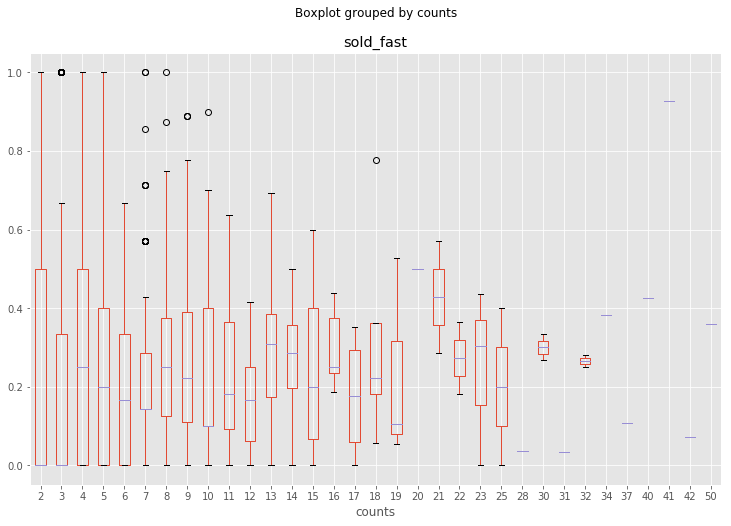

In [0]:
def top_owners(df, y, plot = False, min_count=2):
    df['sold_fast'] = y
    owners = df.groupby(by='owner_id').sold_fast.mean()
    counts = df.owner_id.value_counts()
    owners_counts = pd.DataFrame({'sold_fast':owners,'counts':counts}).sort_values('counts',ascending =  False)
    owners_counts['count_sold_fast'] = owners_counts.sold_fast * owners_counts.counts
    owners_counts = owners_counts[owners_counts.counts>=min_count]
    owners_counts_top = owners_counts[owners_counts.sold_fast>0.5].sort_values('sold_fast', ascending=False)
    if plot:
    owners_counts.boxplot('sold_fast','counts')
    return owners_counts_top
top_owners(df, df.sold_fast, True).tail(5)

Возвращаем только 0 класс

In [0]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop('sold_fast', axis=1), df.sold_fast, 
                                                     random_state=42, shuffle=True,test_size=0.1)
prediction = np.zeros(X_test.shape[0])
prediction

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
report(y_test,prediction)

Accuracy 0.769791340487916 ROC AUC 0.5
              precision    recall  f1-score   support

           0       0.77      1.00      0.87     27042
           1       0.00      0.00      0.00      8087

    accuracy                           0.77     35129
   macro avg       0.38      0.50      0.43     35129
weighted avg       0.59      0.77      0.67     35129



,Predicted neg,Predicted pos
True neg,27042,0
True pos,8087,0


Используем информацию о средней скорости продажи по продавцам: 

In [0]:
owners_counts_top = top_owners(X_train,y_train, False, min_count=1)
for i, owner in enumerate(X_test.owner_id):
    if owner in owners_counts_top.index.values:
        prediction[i] = owners_counts_top.sold_fast[owner]

In [0]:
len(prediction[prediction !=0])

1344

In [0]:
report(y_test,prediction)

Accuracy 0.75333769819807 ROC AUC 0.5058574598021899
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     27042
           1       0.28      0.05      0.08      8087

    accuracy                           0.75     35129
   macro avg       0.53      0.51      0.47     35129
weighted avg       0.66      0.75      0.68     35129



,Predicted neg,Predicted pos
True neg,26081,961
True pos,7704,383


Предсказание для тестовой выборки:
- c продавцами - 0.50407 на kaggle!

In [0]:
prediction = np.zeros(df_test.shape[0])
owners_counts_top = top_owners(df,df.sold_fast, False, min_count=1)
for i, owner in enumerate(df_test.owner_id):
    if owner in owners_counts_top.index.values:
        prediction[i] = owners_counts_top.sold_fast[owner]

In [0]:
len(prediction[prediction !=0])

2454

In [0]:
#save prediction
answer = pd.DataFrame(zip(np.array(df_test.product_id), prediction), columns=['product_id', 'score'])
answer.to_csv('zero_answer.csv', index=False)
answer.head()

,product_id,score
0,86156cd607c3238af8982aebc99ae6a5,0.0
1,76a35a1b4a2d869abfda3365d7cd4c45,0.0
2,c339765b077a730a5367c5310c64128d,0.0
3,b3ec786129b0b3bd7dcbce29d6d6232d,0.0
4,751a58cadb565feb070c2a29dd401438,0.0


In [0]:
#download from colab
from google.colab import files
files.download('zero_answer.csv')

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

**Краткий обзор наших попыток:**

Во всех случаях мы использовали encoding всех категориальных фич, логарифмировали price, чтобы нивелироваливать ее слишком большие значения. Добавили city_population и region_population, т.к. подумали, что это должно коррелировать с доступностью продаваемых товаров - количеством аэропортов\портов\средств транспорта в городе\регионе, что влияет на возможность доставки. Местоположение не использовали, т.к. оно примерно одинаковое у быстро и не быстро раскупаемых товаров. Также мы распарсили date_created на день, месяц и день недели(год везде один и тот же). name_text и desc_text обрабывали несколькими способами.

1.  Без использования текста ~0.62 у нас, на kaggle 0.61241
2.  Использовали lemmatizer и tfidf отдельно на name_text и desc_text, стекинг 2х моделей для текста и 1 обычной, балансироали обучающую выборку с соотношением классов 1:1, соответственно использовали только половину данных. на kaggle - 0.52103
3. Использовали lemmatizer и tfidf отдельно на name_text и desc_text, стекинг 2х моделей для текста и 1 обычной, без балансировки, xgboost sample 0.5 - на kaggle 0.61149
4. Использовали lemmatizer, для смердженных name_text, desc_text, добавили fastext вместо tfidf, без балансировки - на kaggle 0.61669
5. Использовали lemmatizer, для смердженных name_text, desc_text, добавили fastext вместо tfidf, без балансировки, добавли owner_id - на kaggle 0.61695
6. Использовали lemmatizer, для смердженных name_text, desc_text, добавили fastext вместо tfidf, без балансировки, добавли owner_id, slug_id_num  - на kaggle 0.61706


In [0]:
%%time
add_dates(df)

CPU times: user 4.6 s, sys: 8.07 ms, total: 4.6 s
Wall time: 4.61 s


In [0]:
%%time
categorical_means_by_name = dict()

categorical_features = ['category_id', 'subcategory_id', 'region', 'city', 
                        'product_type', 'weekday', 'month','owner_id']

# non_strict_mean_features = ['weekday', 'month']

for name in categorical_features:
    # should we set 0.5 if there are < 3 occurrences
#     count_limit = 0 if name in non_strict_mean_features else 3
    means = get_categorical_means(df, name)
    
    categorical_means_by_name[name] = means
    encode_categorical(df, name, means)


encode_one_hot(df, 'sold_mode')

added category_id_encoded
added subcategory_id_encoded
added region_encoded
added city_encoded
added product_type_encoded
added weekday_encoded
added month_encoded
added owner_id_encoded
CPU times: user 31.5 s, sys: 30.5 ms, total: 31.5 s
Wall time: 31.5 s


In [0]:
def add_price_log(df):
    df.price[df.price == 0] = 0.0001
    df['price_log'] = np.log(df.price)
    
add_price_log(df)

In [0]:
add_city_region_population(df)

### tfidf adding to normal features - sparse & stacking

In [0]:
features = ['delivery_available',
       'img_num', 'payment_available', 'product_type_encoded', 'sold_mode_2',
       'city_population', 'region_population', 'category_id_encoded',
       'subcategory_id_encoded', 'region_encoded', 'city_encoded', 'day',
       'month_encoded', 'weekday_encoded', 'price_log']


# features = ['delivery_available',
#        'img_num', 'payment_available', 'price', 'sold_mode_1', 'sold_mode_2',
#        'day',
#        'month', 'weekday']

In [0]:
# split 3 parts
X_train, X_test, y_train, y_test  = train_test_split(df.drop('sold_fast', axis=1), df.sold_fast, 
                                                     random_state=42, shuffle=True)
X_val, X_test, y_val, y_test  = train_test_split(X_test, y_test, 
                                                     random_state=42, shuffle=True)
# Reset index
X_val = X_val.reset_index()
X_test = X_test.reset_index()

# Balance train!
X_train, y_train = balance_train(X_train, y_train)

Try add features as sparse matrix to tfidf resluts

In [0]:
from scipy.sparse import coo_matrix
import scipy.sparse as sps
def append_sparsed(X, tfidf):
    X_sparse = coo_matrix(X).tocsr()
    return sps.hstack([tfidf, X_sparse])

In [0]:
tfidf, tfidf_val, tfidf_test = get_tfidf(X_train.lemmatized_descr,X_val.lemmatized_descr,X_test.lemmatized_descr)
tfidf_name, tfidf_val_name, tfidf_test_name = get_tfidf(X_train.lemmatized_name,X_val.lemmatized_name,X_test.lemmatized_name)

tfidf_merge = sps.hstack([tfidf, tfidf_name])
tfidf_merge_val = sps.hstack([tfidf_val, tfidf_val_name])
tfidf_merge_test = sps.hstack([tfidf_test, tfidf_test_name])

X_train_merge = append_sparsed(X_train[features], tfidf_merge) 
X_val_merge = append_sparsed(X_val[features], tfidf_merge_val)
X_test_merge = append_sparsed(X_test[features], tfidf_merge_test)

In [0]:
#со sparse
%%time
from xgboost import XGBClassifier

#clf = RandomForestClassifier(n_estimators=100, n_jobs=3, class_weight='balanced', min_samples_leaf=100)
clf = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=3, n_jobs=2, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)
#clf = KNeighborsClassifier(n_neighbors=20)
#clf = LogisticRegression()
clf.fit(X_train_merge, y_train)

y_train_pred = clf.predict_proba(X_train_merge)[:, 1]
y_test_pred = clf.predict_proba(X_val_merge)[:, 1]
y_pred = clf.predict(X_test_merge)

from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_val, y_test_pred)

print("Train AUC: ", auc_train)
print("Test AUC: ", auc_test)

Train AUC:  0.6481107368735926
Test AUC:  0.632837742320282
CPU times: user 2min, sys: 213 ms, total: 2min
Wall time: 1min 1s


Try stacking models

In [0]:
tfidf_train1, tfidf_train2, y_train1, y_train2  = train_test_split(tfidf_merge, y_train, 
                                                     random_state=42, shuffle=True, test_size=0.5)

In [0]:
%%time
#1st part
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=3, n_jobs=-1, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)

clf.fit(tfidf_train1, y_train1)

y_pred2 = clf.predict(tfidf_train2)
y_val2 = clf.predict(tfidf_merge_val)
print(accuracy_score(y_pred2, y_train2), roc_auc_score(y_pred2, y_train2))

0.5615972951680672 0.5684957512740387
CPU times: user 38.5 s, sys: 73.5 ms, total: 38.6 s
Wall time: 19.7 s


In [0]:
%%time
#2nd part
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=3, n_jobs=-1, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)

clf.fit(tfidf_train2, y_train2)

y_pred1 = clf.predict(tfidf_train1)
y_val1 = clf.predict(tfidf_merge_val)
print(accuracy_score(y_pred1, y_train1), roc_auc_score(y_pred1, y_train1))

0.5690651260504201 0.5735508778704554
CPU times: user 38 s, sys: 63.2 ms, total: 38 s
Wall time: 19.4 s


In [0]:
y_pred_tfidf = pd.DataFrame(np.concatenate([y_pred1,y_pred2]))
y_pred_val_tfidf = pd.DataFrame(0.5*(y_val1+ y_val2))

X_train_second = pd.concat([ y_pred_tfidf, X_train[features]],axis=1)
X_val_second = pd.concat([y_pred_val_tfidf, X_val[features]],axis=1)


In [0]:
#со стекингом
%%time
from xgboost import XGBClassifier

#clf = RandomForestClassifier(n_estimators=100, n_jobs=3, class_weight='balanced', min_samples_leaf=100)
clf = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=3, n_jobs=2, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)
#clf = KNeighborsClassifier(n_neighbors=20)
#clf = LogisticRegression()
clf.fit(X_train_second, y_train)

y_train_pred = clf.predict_proba(X_train_second)[:, 1]
y_test_pred = clf.predict_proba(X_val_second)[:, 1]
y_pred = clf.predict(X_val_second)

from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_val, y_test_pred)

print("Train AUC: ", auc_train)
print("Test AUC: ", auc_test)

Train AUC:  0.6415658804936123
Test AUC:  0.6361424853585976
CPU times: user 1min 4s, sys: 58.4 ms, total: 1min 4s
Wall time: 32.7 s


Стекинг лучше!)

##Fasttext pipeline

In [0]:
# df_balanced = balance_data(df)

In [0]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df, df.sold_fast,
                                                    test_size=0.25, random_state=42, shuffle=True)

add_fast_text(X_train, y_train, X_test, epoch=6, lr=0.1, bucket=500_000, thread=2)


ft1 fitted
ft2 fitted
roc_auc part1: 0.5911186930204182
roc_auc part2: 0.5896850438367486
fasttext added!!
CPU times: user 26.6 s, sys: 1.29 s, total: 27.9 s
Wall time: 19.2 s


In [0]:
max_text_width(20)
X_train.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,city_population,region_population,day,month,weekday,lemmatized_descr,category_id_encoded,subcategory_id_encoded,region_encoded,city_encoded,product_type_encoded,weekday_encoded,month_encoded,owner_id_encoded,sold_mode_1,sold_mode_2,price_log,slug_id,sulg_id_num,sulg_id_num_num,sulg_id_num_by_subcategory_id,slug_id_2,slug_id_3,slug_id_3_by_subcategory_id,slug_id_4,fasttext
412893,15,Севастополь,2018-01-30,0,За все 200 рублей,1,44.6121,33.5222,От пк,bd6b6673d90f85d0...,0,200.0,961951de0a1eed3e...,1,[],Республика Крым,1,1508,1,393304,1900000,30,1,2,пк . весь 200 рубль,0.263248,0.260606,0.203297,0.217320,0.232291,0.232695,0.241677,0.5,1,0,5.298317,[],0.000000,0.000000,0.000000,[],0.000000,0.000000,0.000000,0.140625
389098,11,Прохладный,2018-04-14,0,Показывает калло...,2,43.7587,44.0327,Велотренажер,bc21d44a048c81ad...,0,6500.0,9e5db4c72ce8371e...,1,[],Кабардино-Балкария,1,1103,0,59595,1900000,14,4,6,велотренажер . п...,0.257361,0.229075,0.236074,0.200000,0.232291,0.238190,0.241951,0.0,1,0,8.779557,[],0.000000,0.000000,0.000000,[],0.000000,0.000000,0.000000,0.259766
386121,8,Новосибирск,2018-09-15,1,Продам костюм фи...,4,55.0083,82.9376,Костюм фирменный...,f0249d6609fe8c68...,1,5000.0,084f842a5c526c84...,1,[{'slug_id': 'mu...,Новосибирская об...,1,803,0,1473737,2665853,15,9,6,костюм фирменный...,0.178159,0.184539,0.232747,0.234017,0.232291,0.238190,0.151140,0.5,1,0,8.517193,[muzhskaya_odezh...,0.882110,0.684300,0.684300,[0.0032354641767...,0.007345,0.005698,0.008327,0.138672
5963,6,Нижний Тагил,2018-01-22,0,хорошие двери. д...,4,57.8647,59.9471,входные двери БУ...,19845423708198a9...,1,5000.0,01e730d426d352e5...,1,[{'slug_id': 'dv...,Свердловская обл...,1,609,1,361883,4298030,22,1,1,входной дверь бу...,0.245572,0.272097,0.234268,0.192703,0.232291,0.225913,0.241677,0.5,1,0,8.517193,[dveri_tip],1.954657,1.609484,1.609484,[0.0008007578121...,0.000801,0.000659,0.000410,0.341797
40954,1,Сургут,2018-03-25,0,"Без дисков , 4 ш...",4,61.2757,73.3654,Nokian nordman sx,720ef61c55795e8b...,0,7000.0,bf62722c8d02fae8...,1,[{'slug_id': 'sh...,Ханты-Мансийский...,1,114,0,306703,1531973,25,3,7,nokian nordman s...,0.204183,0.245217,0.249068,0.250205,0.232291,0.223383,0.229333,0.5,1,0,8.853665,[shiny_sezonnost...,2.277748,1.118532,1.118532,[0.0053413677524...,0.025727,0.012634,0.011295,0.130859


In [0]:
from xgboost import XGBClassifier

features = ['delivery_available',
       'img_num', 'payment_available', 'product_type_encoded', 'sold_mode_2',
       'city_population', 'region_population', 'category_id_encoded',
       'subcategory_id_encoded', 'region_encoded', 'city_encoded', 'day',
       'month_encoded', 'weekday_encoded', 'price_log', 'owner_id_encoded', 
            'fasttext']


clf = XGBClassifier(n_estimators=100, learning_rate=0.02, max_depth=3, n_jobs=2, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)
clf.fit(X_train[features], y_train)

y_train_pred = clf.predict_proba(X_train[features])[:, 1]
y_test_pred = clf.predict_proba(X_test[features])[:, 1]
y_pred = clf.predict(X_test[features])

# y_train_pred = X_train.fasttext
# y_test_pred = X_test.fasttext

from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print("Train AUC: ", auc_train)
print("Test AUC: ", auc_test)

Train AUC:  0.6357824275926617
Test AUC:  0.6339567253231351


Без owner_id(->4ая попытка на kaggle 0.61669):
- Train AUC: 0.6289358755559424 
- Test AUC: 0.6282893765968247

C owner_id:(->5ая попытка на kaggle 0.61695)
- Train AUC: 0.6354059257644855
- Test  AUC:  0.633990974553288




In [0]:
#feature importances
sorted(clf.get_booster().get_fscore().items(), key=lambda kv: -kv[1])

[('owner_id_encoded', 173),
 ('subcategory_id_encoded', 120),
 ('month_encoded', 86),
 ('fasttext', 79),
 ('price_log', 74),
 ('city_encoded', 60),
 ('category_id_encoded', 52),
 ('day', 16),
 ('region_encoded', 8),
 ('payment_available', 6),
 ('img_num', 3),
 ('region_population', 3),
 ('weekday_encoded', 2),
 ('city_population', 2)]

Text(0.5, 0, 'FPR')

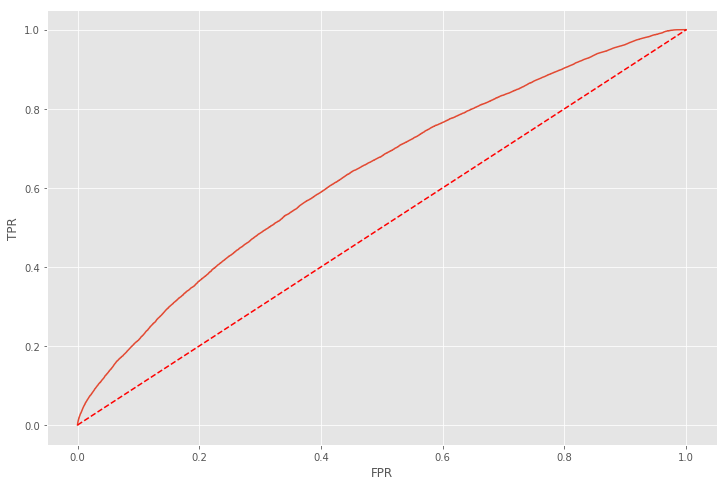

In [0]:
fpr, tpr, tresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

Text(0.5, 0, 'Recall')

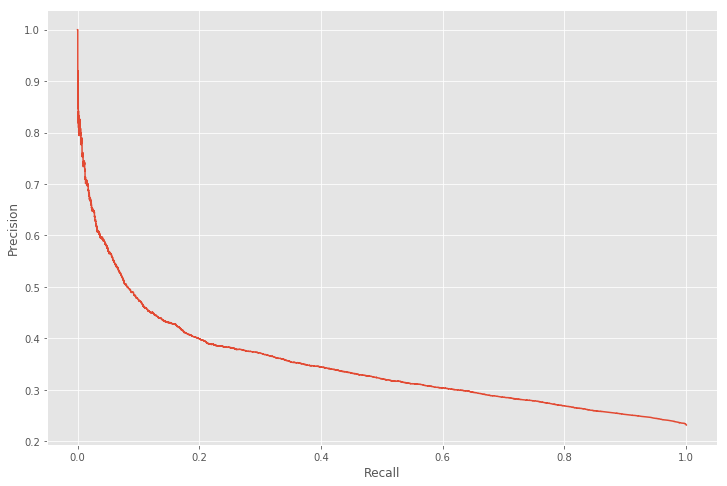

In [0]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
plt.plot(recall,precision)
plt.ylabel('Precision')
plt.xlabel('Recall')

## Tuning parameters

In [0]:
import xgboost as xgb
from xgboost import DMatrix, XGBClassifier

import random
grr_index = random.sample(range(len(y_train)), 5000) #50000
X_train_grr = X_train.iloc[grr_index,:]
y_train_grr = y_train[grr_index]
X_train_grr.shape

(5000, 35)

In [0]:
def modelfit(alg, X_train, y_train, features, useTrainCV=True, cv_folds=3, early_stopping_rounds=10):
    X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, 
                                                     random_state=42, shuffle=True)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train_grr[features], label=y_train_grr)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,seed=42,shuffle=True,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    
    
    #Fit the algorithm on the data
    alg.fit(X_train[features], y_train,eval_metric='auc')
        
    #Predict training set:
    y_train_pred = alg.predict_proba(X_train[features])[:, 1]
    y_val_pred_prob = alg.predict_proba(X_val[features])[:, 1]
    y_val_pred = alg.predict(X_val[features])
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Train): %f" % roc_auc_score(y_train, y_train_pred))           
    print("AUC Score (Validation): %f" % roc_auc_score(y_val, y_val_pred_prob))
    print(classification_report(y_val, y_val_pred, target_names=['0','1']))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return conf_matrix(y_val,y_val_pred)

[0]	train-auc:0.601461+0.00489212	test-auc:0.573935+0.0116759
[1]	train-auc:0.623096+0.0113382	test-auc:0.586672+0.0146225
[2]	train-auc:0.633733+0.0116061	test-auc:0.593527+0.0174367
[3]	train-auc:0.6373+0.00763243	test-auc:0.592248+0.0203561
[4]	train-auc:0.63881+0.0122822	test-auc:0.59444+0.0164624
[5]	train-auc:0.644481+0.00974214	test-auc:0.599743+0.0161563
[6]	train-auc:0.645813+0.00991117	test-auc:0.604546+0.0170886
[7]	train-auc:0.648426+0.00785874	test-auc:0.608221+0.017079
[8]	train-auc:0.648607+0.00797869	test-auc:0.609104+0.0174159
[9]	train-auc:0.649627+0.00886319	test-auc:0.6086+0.0154925
[10]	train-auc:0.649647+0.00959173	test-auc:0.607394+0.0148043
[11]	train-auc:0.650283+0.00868529	test-auc:0.607243+0.0148475
[12]	train-auc:0.650935+0.00937807	test-auc:0.608704+0.0139665
[13]	train-auc:0.649904+0.00946076	test-auc:0.609476+0.0119803


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14]	train-auc:0.650631+0.0086621	test-auc:0.610198+0.0129483
[15]	train-auc:0.651509+0.00865704	test-auc:0.610937+0.0137876
[16]	train-auc:0.65219+0.00900286	test-auc:0.612482+0.0132953
[17]	train-auc:0.653106+0.00927623	test-auc:0.612431+0.0135307
[18]	train-auc:0.653615+0.00927209	test-auc:0.61251+0.0141434
[19]	train-auc:0.653835+0.00815605	test-auc:0.613096+0.0142743
[20]	train-auc:0.653697+0.00752089	test-auc:0.613132+0.01383
[21]	train-auc:0.653278+0.00774903	test-auc:0.613053+0.0136359
[22]	train-auc:0.654113+0.00788821	test-auc:0.612814+0.0142185
[23]	train-auc:0.655757+0.00697295	test-auc:0.613551+0.0149633
[24]	train-auc:0.656367+0.00730106	test-auc:0.613116+0.0147128
[25]	train-auc:0.656995+0.00692804	test-auc:0.613469+0.0152714
[26]	train-auc:0.656825+0.0066368	test-auc:0.613865+0.0148835
[27]	train-auc:0.65866+0.00770308	test-auc:0.614012+0.015564
[28]	train-auc:0.658801+0.00735867	test-auc:0.61494+0.0149713
[29]	train-auc:0.658703+0.00715099	test-auc:0.615465+0.0145579
[

,Predicted neg,Predicted pos
True neg,285,326
True pos,219,420


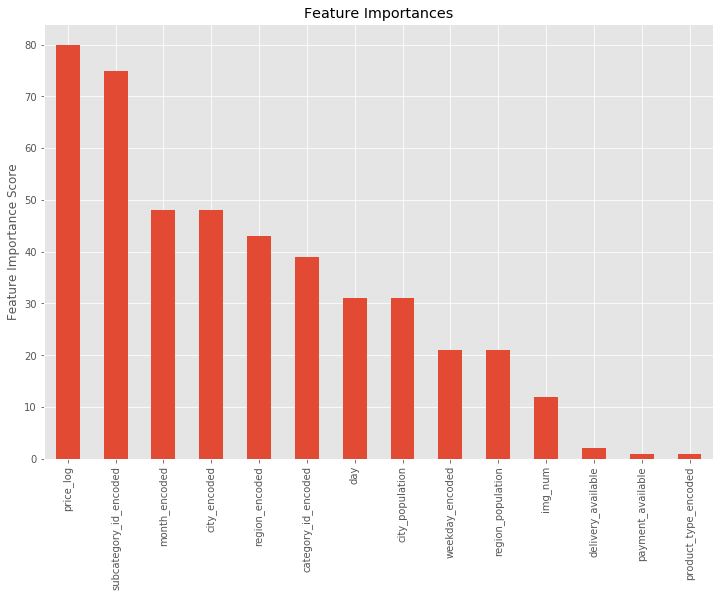

In [0]:
xgb1 = XGBClassifier(random_seed=42, n_estimators=100, learning_rate=0.02, max_depth=3, n_jobs=2, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)
modelfit(xgb1, X_train_grr, y_train_grr, features)

In [0]:
param_test0 = {
 'n_estimators':range(300,800,100), #было 100-1000
    
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.113, n_estimators=600, 
   max_depth=3,subsample=0.7, colsample_bytree=0.9, scale_pos_weight=1.,min_child_weight = 3.,
 objective= 'binary:logistic', njobs=-1, seed=42), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=-1,iid=False, cv=3)

gsearch1.fit(X_train[features],y_train)
gsearch1.best_index_, gsearch1.best_params_, gsearch1.best_score_

(0, {'n_estimators': 300}, 0.6385556349309008)

In [0]:
gsearch1.cv_results_

{'mean_fit_time': array([25.88314025, 35.1590511 , 43.69784172, 52.06620646, 56.24292986]),
 'mean_score_time': array([0.6010855 , 0.77533221, 0.95779816, 1.14616831, 1.2394944 ]),
 'mean_test_score': array([0.63855563, 0.63815063, 0.63758773, 0.63724514, 0.63661897]),
 'param_n_estimators': masked_array(data=[300, 400, 500, 600, 700],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 300},
  {'n_estimators': 400},
  {'n_estimators': 500},
  {'n_estimators': 600},
  {'n_estimators': 700}],
 'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32),
 'split0_test_score': array([0.63920451, 0.63889238, 0.63810282, 0.63782044, 0.63730965]),
 'split1_test_score': array([0.6378785 , 0.63727541, 0.63677646, 0.63648684, 0.63594648]),
 'split2_test_score': array([0.6385839 , 0.63828411, 0.63788392, 0.63742813, 0.63660078]),
 'std_fit_time': array([0.32048632, 0.27398348, 0.16949718, 0.34916973, 6.20828035]),
 '

In [0]:
param_test1 = {
 #scale_pos_weight = 1 because high class imbalance!
 'max_depth':range(2,10,2), # range(2,4,1) ... #3-4
 'min_child_weight':range(1,6,1) # 3(2)
    
 #'subsample':np.linspace(0.1,0.9,5), # 0.6-0.7
 #'colsample_bytree':np.linspace(0.1,0.9,5)  # 0.9
    
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=3,
  subsample=0.5, colsample_bytree=0.5, scale_pos_weight=1.,
 objective= 'binary:logistic', njobs=3, seed=42), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=3,iid=False, cv=5)

gsearch1.fit(X_train_grr[features],y_train_grr)
gsearch1.best_index_, gsearch1.best_params_, gsearch1.best_score_

(1, {'max_depth': 2, 'min_child_weight': 2}, 0.6182811216856888)

In [0]:
#gsearch1.cv_results_


In [0]:
xgb2 = XGBClassifier(random_seed=42,
 n_estimators=600, learning_rate=0.1, max_depth=3, n_jobs=2, min_child_weight = 3.,
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)
modelfit(xgb2, X_train_grr, y_train_grr, features)

In [0]:
param_test2 = {
 'learning_rate':np.linspace(0.07, 0.2, 10) # 0.113
  #'gamma': np.random.uniform(1e-9, 0.5, 10),
  #'alpha': np.random.uniform(1e-9, 0.5, 10),  
  
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.113, n_estimators=100, 
                    max_depth=3, n_jobs=3, min_child_weight = 3.,
                    colsample_bytree=0.9, scale_pos_weight=1., subsample=0.7), 
param_grid = param_test2, scoring='roc_auc',n_jobs=3,iid=False, cv=3)

gsearch2.fit(X_train_grr[features],y_train_grr)
gsearch2.best_index_, gsearch2.best_params_, gsearch2.best_score_

(0, {'alpha': 0.09992063644112847}, 0.6141783139218945)

[0]	train-auc:0.605431+0.00906979	test-auc:0.571859+0.00718324
[1]	train-auc:0.631463+0.006505	test-auc:0.594605+0.0107236
[2]	train-auc:0.640379+0.00617203	test-auc:0.600091+0.0168578
[3]	train-auc:0.646199+0.00442177	test-auc:0.604084+0.0185194
[4]	train-auc:0.649432+0.00544616	test-auc:0.605351+0.0151837
[5]	train-auc:0.653882+0.00626781	test-auc:0.610747+0.0160105
[6]	train-auc:0.656274+0.00579162	test-auc:0.609802+0.0149504
[7]	train-auc:0.659297+0.00549589	test-auc:0.609952+0.0166461
[8]	train-auc:0.660555+0.00489013	test-auc:0.610688+0.0165737
[9]	train-auc:0.662926+0.00493235	test-auc:0.611878+0.020052


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10]	train-auc:0.664926+0.00595731	test-auc:0.611206+0.0202756
[11]	train-auc:0.666172+0.00504947	test-auc:0.612062+0.0192664
[12]	train-auc:0.666915+0.00448516	test-auc:0.613758+0.0191851
[13]	train-auc:0.668366+0.00526251	test-auc:0.613655+0.0198726
[14]	train-auc:0.670048+0.00581022	test-auc:0.613781+0.0203125
[15]	train-auc:0.670679+0.00566355	test-auc:0.615187+0.0188946
[16]	train-auc:0.671984+0.00564869	test-auc:0.615548+0.0178978
[17]	train-auc:0.673373+0.00521515	test-auc:0.615911+0.01856
[18]	train-auc:0.675289+0.00514614	test-auc:0.616209+0.019621
[19]	train-auc:0.67645+0.00435304	test-auc:0.616466+0.0198027
[20]	train-auc:0.677996+0.0048162	test-auc:0.616693+0.0208625
[21]	train-auc:0.679097+0.00474506	test-auc:0.61617+0.0203976
[22]	train-auc:0.680103+0.00484642	test-auc:0.616231+0.0207815
[23]	train-auc:0.681194+0.00488074	test-auc:0.616804+0.0206847
[24]	train-auc:0.682781+0.00453596	test-auc:0.616304+0.0210726
[25]	train-auc:0.683917+0.00397756	test-auc:0.616043+0.021248

,Predicted neg,Predicted pos
True neg,297,314
True pos,220,419


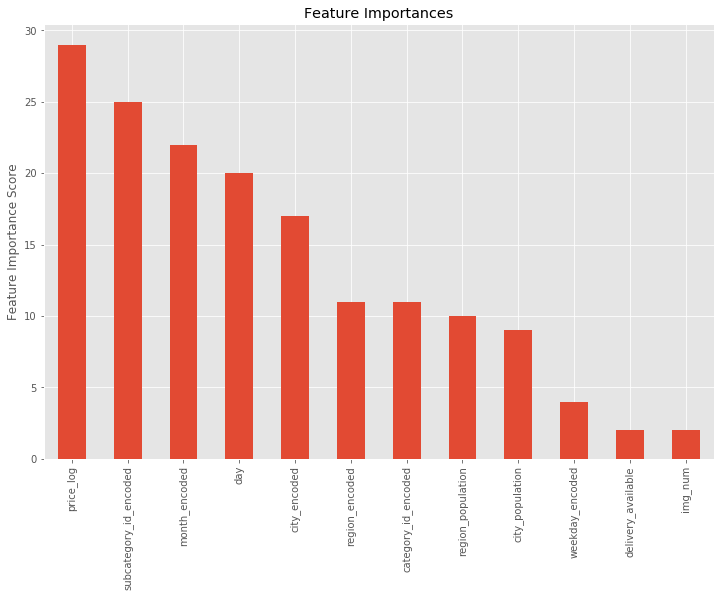

In [0]:
xgb3 = XGBClassifier(random_seed=42,
 n_estimators=100, learning_rate=0.113, max_depth=3, n_jobs=3, min_child_weight = 3.,
                    colsample_bytree=0.9, scale_pos_weight=1., subsample=0.7)
modelfit(xgb3, X_train_grr, y_train_grr, features)

## Prediction itself

In [0]:
max_text_width(20)
df_test.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id
0,9,Челябинск,2018-10-22,True,Ботильоны канадс...,3,55.2639,61.3972,Ботильоны,4ec4746e62084fba...,True,650.0,86156cd607c3238a...,1,[{'slug_id': 'so...,Челябинская область,1,902
3,22,Барнаул,2018-11-09,True,Зимний костюм. К...,2,53.3426,83.7380,Зимний костюм,180b02e19c8c0140...,True,750.0,76a35a1b4a2d869a...,1,[{'slug_id': 'de...,Алтайский край,1,2204
8,12,Чита,2018-11-27,False,Продам прекрасны...,4,52.0883,113.4982,"5.5"" Смартфон Pr...",b9b9b1e11e85acfd...,True,5500.0,c339765b077a730a...,1,[{'slug_id': 'sm...,Забайкальский край,1,1202
9,3,Москва,2018-11-25,True,Горка для купани...,2,55.6932,37.5684,Горка для купания,88c125a4cfa8b806...,True,100.0,b3ec786129b0b3bd...,1,[],Московская область,1,316
19,22,Бердск,2018-11-04,True,Новый! В наличии...,2,54.7648,83.0884,Новый костюм,d82287641ee83c96...,True,700.0,751a58cadb565feb...,1,[{'slug_id': 'de...,Новосибирская об...,1,2214


In [0]:
%%time
make_ints(df_test)
add_dates(df_test)
add_city_region_population(df_test)
add_price_log(df_test)

encode_one_hot(df_test, 'sold_mode')

# use precomputed dicts from train df
for name, means in categorical_means_by_name.items():
    encode_categorical(df_test, name, means)

added category_id_encoded
added subcategory_id_encoded
added region_encoded
added city_encoded
added product_type_encoded
added weekday_encoded
added month_encoded
added owner_id_encoded
CPU times: user 7.35 s, sys: 52.9 ms, total: 7.41 s
Wall time: 7.41 s


In [0]:
descr_test = add_lemmatized_descr(df_test)
#save_lemmatized_descr(lemmatized_texts, 'df_test_lemmatized_descr.txt')
restore_lemmatized_descr(df_test, 'df_test_lemmatized_descr.txt')


saving
saved


In [0]:
df_test.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,day,month,weekday,city_population,region_population,price_log,sold_mode_1,sold_mode_2,category_id_encoded,subcategory_id_encoded,region_encoded,city_encoded,product_type_encoded,weekday_encoded,month_encoded,owner_id_encoded,lemmatized_descr
0,9,Челябинск,2018-10-22,1,Ботильоны канадс...,3,55.2639,61.3972,Ботильоны,4ec4746e62084fba...,1,650.0,86156cd607c3238a...,1,[{'slug_id': 'so...,Челябинская область,1,902,22,10,1,1130273,3478620,6.476972,1,0,0.162397,0.164785,0.229135,0.229716,0.232291,0.225913,0.232392,0.5,ботильон . ботил...
3,22,Барнаул,2018-11-09,1,Зимний костюм. К...,2,53.3426,83.7380,Зимний костюм,180b02e19c8c0140...,1,750.0,76a35a1b4a2d869a...,1,[{'slug_id': 'de...,Алтайский край,1,2204,9,11,5,612091,2419379,6.620073,1,0,0.169870,0.166390,0.242036,0.248002,0.232291,0.231854,0.500000,0.5,зимний костюм . ...
8,12,Чита,2018-11-27,0,Продам прекрасны...,4,52.0883,113.4982,"5.5"" Смартфон Pr...",b9b9b1e11e85acfd...,1,5500.0,c339765b077a730a...,1,[{'slug_id': 'sm...,Забайкальский край,1,1202,27,11,2,323964,1106611,8.612503,1,0,0.293339,0.306455,0.250206,0.250707,0.232291,0.232695,0.500000,0.5,"5 . 5 "" смартфон..."
9,3,Москва,2018-11-25,1,Горка для купани...,2,55.6932,37.5684,Горка для купания,88c125a4cfa8b806...,1,100.0,b3ec786129b0b3bd...,1,[],Московская область,1,316,25,11,7,11514330,7092941,4.605170,1,0,0.237816,0.182227,0.227684,0.230473,0.232291,0.223383,0.500000,0.5,горка купание . ...
19,22,Бердск,2018-11-04,1,Новый! В наличии...,2,54.7648,83.0884,Новый костюм,d82287641ee83c96...,1,700.0,751a58cadb565feb...,1,[{'slug_id': 'de...,Новосибирская об...,1,2214,4,11,7,97288,2665853,6.551080,1,0,0.169870,0.149691,0.232747,0.215649,0.232291,0.223383,0.500000,0.5,новый костюм . н...


In [0]:
features

['delivery_available',
 'img_num',
 'payment_available',
 'product_type_encoded',
 'sold_mode_2',
 'city_population',
 'region_population',
 'category_id_encoded',
 'subcategory_id_encoded',
 'region_encoded',
 'city_encoded',
 'day',
 'month_encoded',
 'weekday_encoded',
 'price_log',
 'owner_id_encoded',
 'fasttext']

In [0]:
%%time
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=3, n_jobs=2, 
                    colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)

add_fast_text(df, df.sold_fast, df_test, epoch=6, lr=0.1, bucket=500_000, thread=2)

clf.fit(df[features], df.sold_fast)

y_pred = clf.predict_proba(df_test[features])

ft1 fitted
ft2 fitted
roc_auc part1: 0.5939653680196312
roc_auc part2: 0.5925531170416339
fasttext added!!
CPU times: user 6min 26s, sys: 2.52 s, total: 6min 29s
Wall time: 3min 22s


In [0]:
y_pred.shape

(89251, 2)

In [0]:
#save prediction
answer = pd.DataFrame(zip(np.array(df_test.product_id), y_pred[:,1]), columns=['product_id', 'score'])
answer.to_csv('answer.csv', index=False)
answer.head()

,product_id,score
0,86156cd607c3238a...,0.157260
1,76a35a1b4a2d869a...,0.172886
2,c339765b077a730a...,0.348859
3,b3ec786129b0b3bd...,0.199012
4,751a58cadb565feb...,0.164509


In [0]:
#download from colab
from google.colab import files
files.download('answer.csv')

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?

Feature importance самой лучшей модели:

Text(0, 0.5, 'Feature Importance Score')

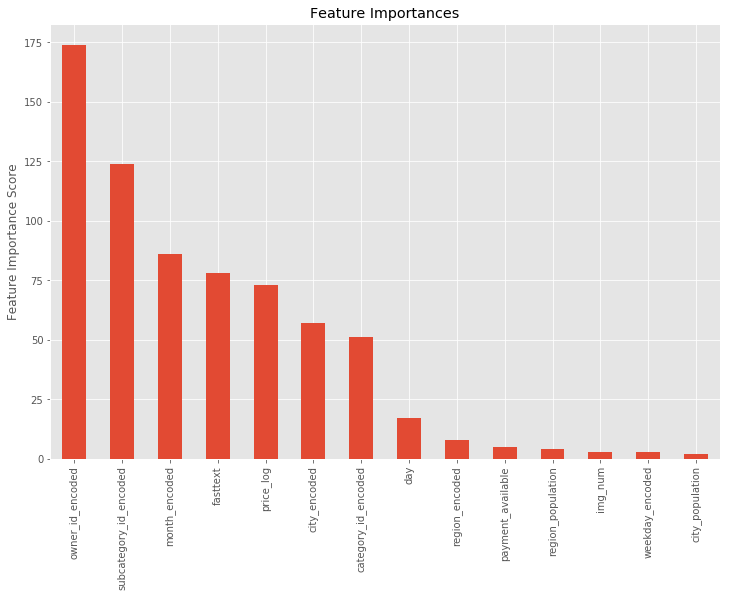

In [0]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Видим, что самое важное - кто продает и в какой субкатегории и конечно месяц, т.к. в разное время года растет спрос на разные категории товаров. Не менее важно описание, оно может как оттолкнуть, так и привлечь покупателя. Также важна цена и город, где находится товар, т.к. далеко не всегда удобно подъехать и забрать товар или не всегда возможна доставка из данного города.

На быструю продажу практически не влияют численность населения города, популярность региона, день недели, количество приложенных картинок. Слабо влияет число месяца в которое был добавлен товар.